A_0= 5464480.87431694
Biot= 15409.836065573769
T_f= 273224.043715847
T_s= 0.0183
T= 5000000
Time step in dimensionless form = 3.6600007320001466e-09
Time step in dimension form = 0.0010000002000000402
T_slice= [0, 3500, 10000, 30000, 150000, 200000, 400000, 4319999]
[ 99. -99.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
length= 5000000


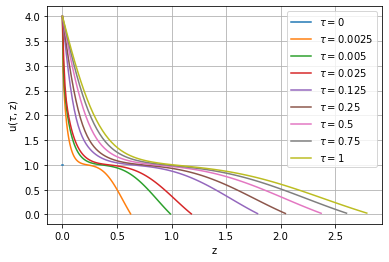

T= [0.0000000e+00 1.0000002e-03 2.0000004e-03 ... 4.9999980e+03 4.9999990e+03
 5.0000000e+03]


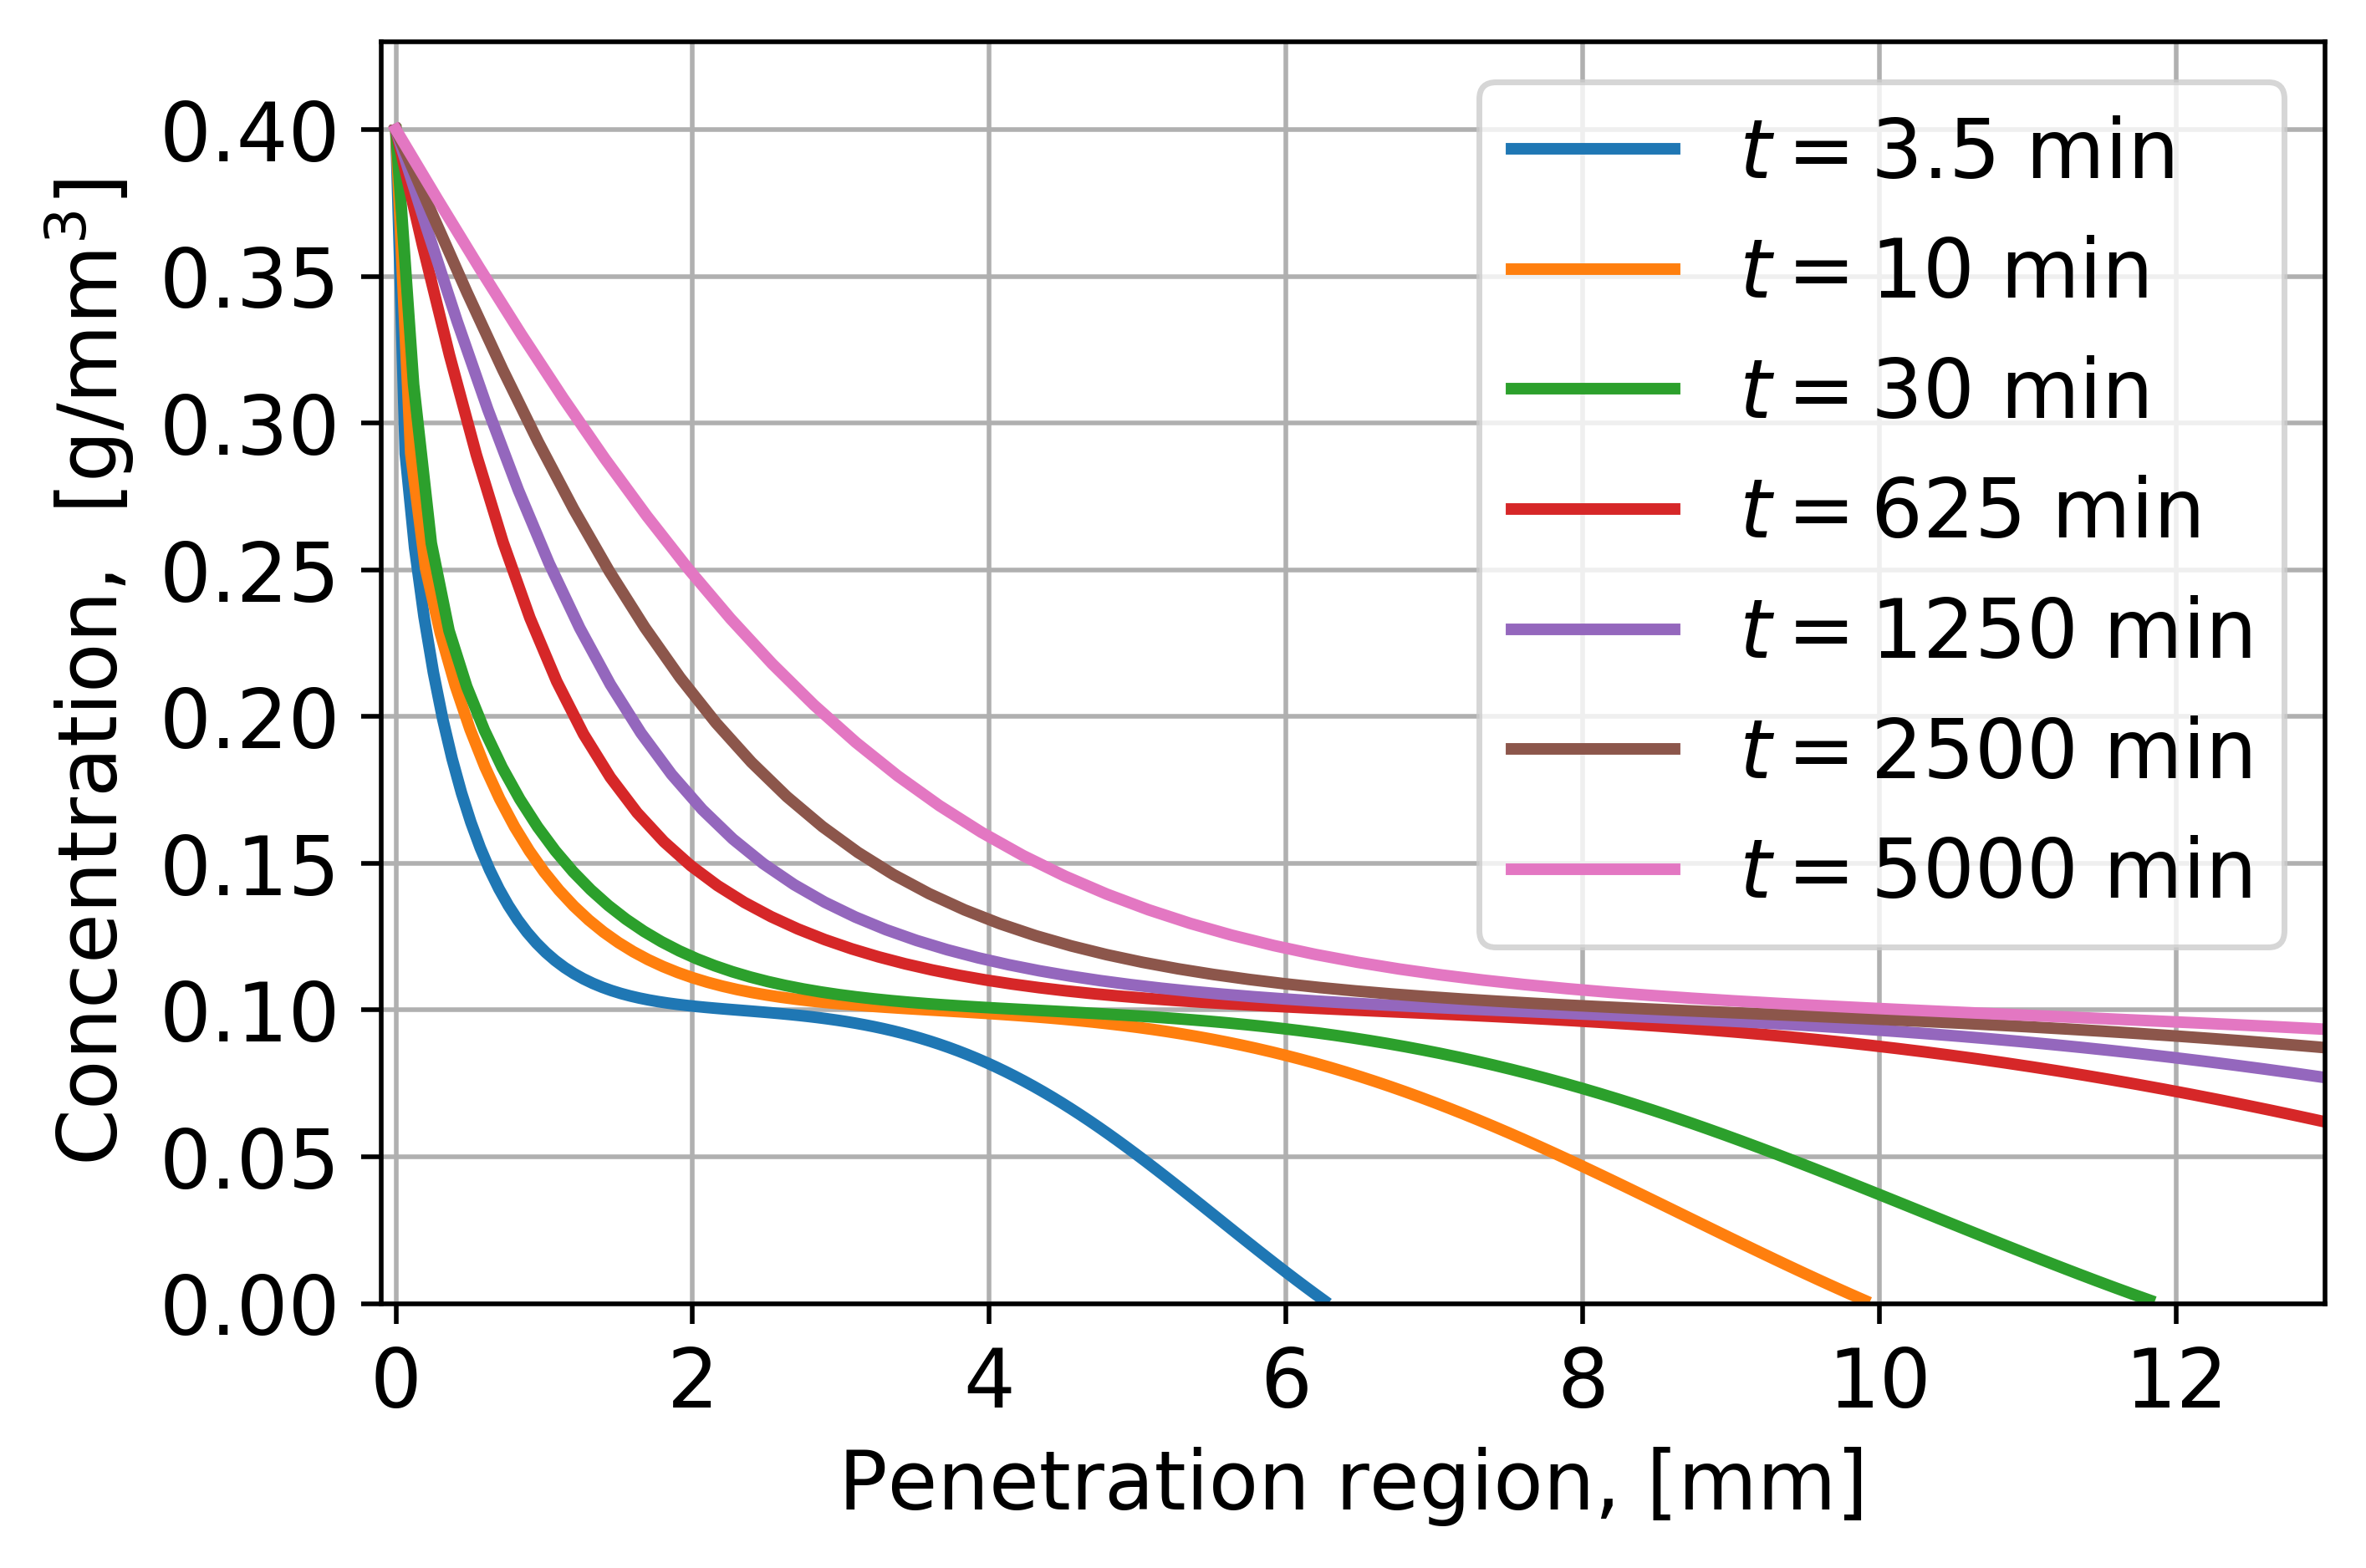

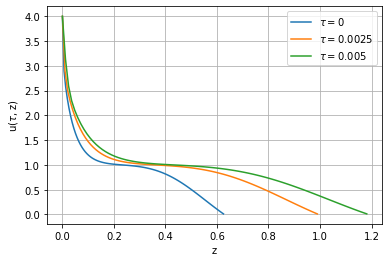

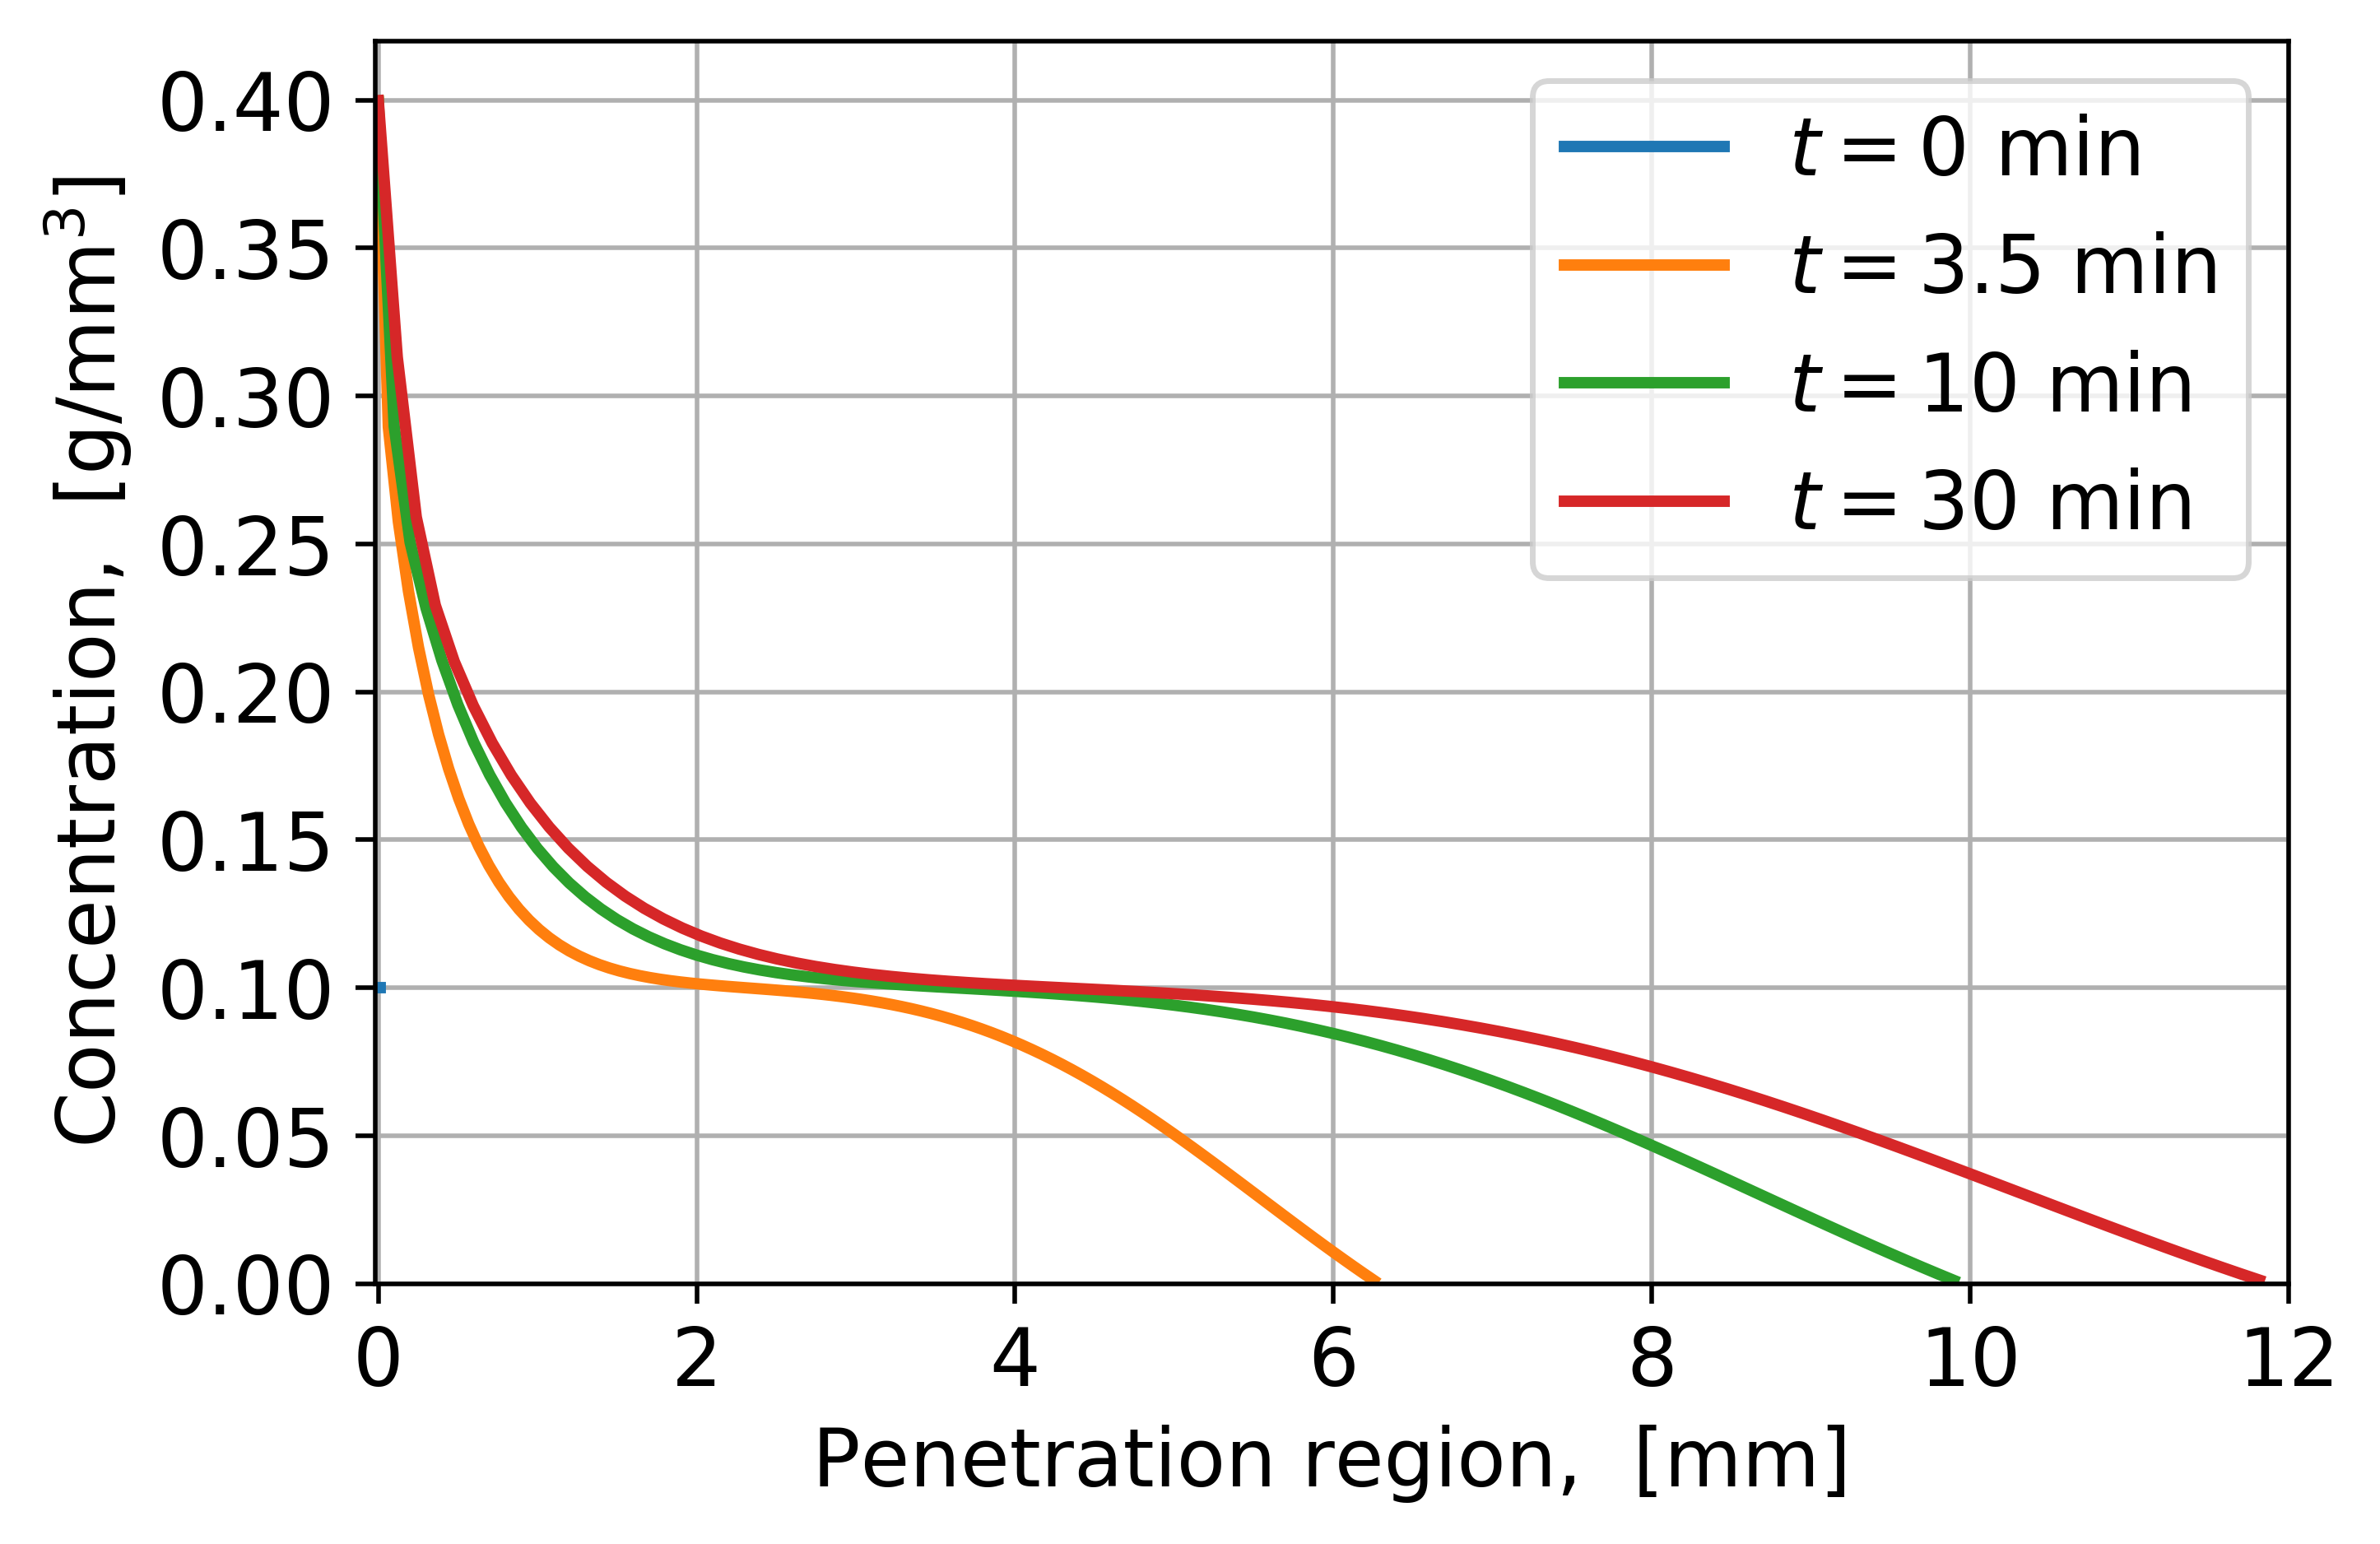

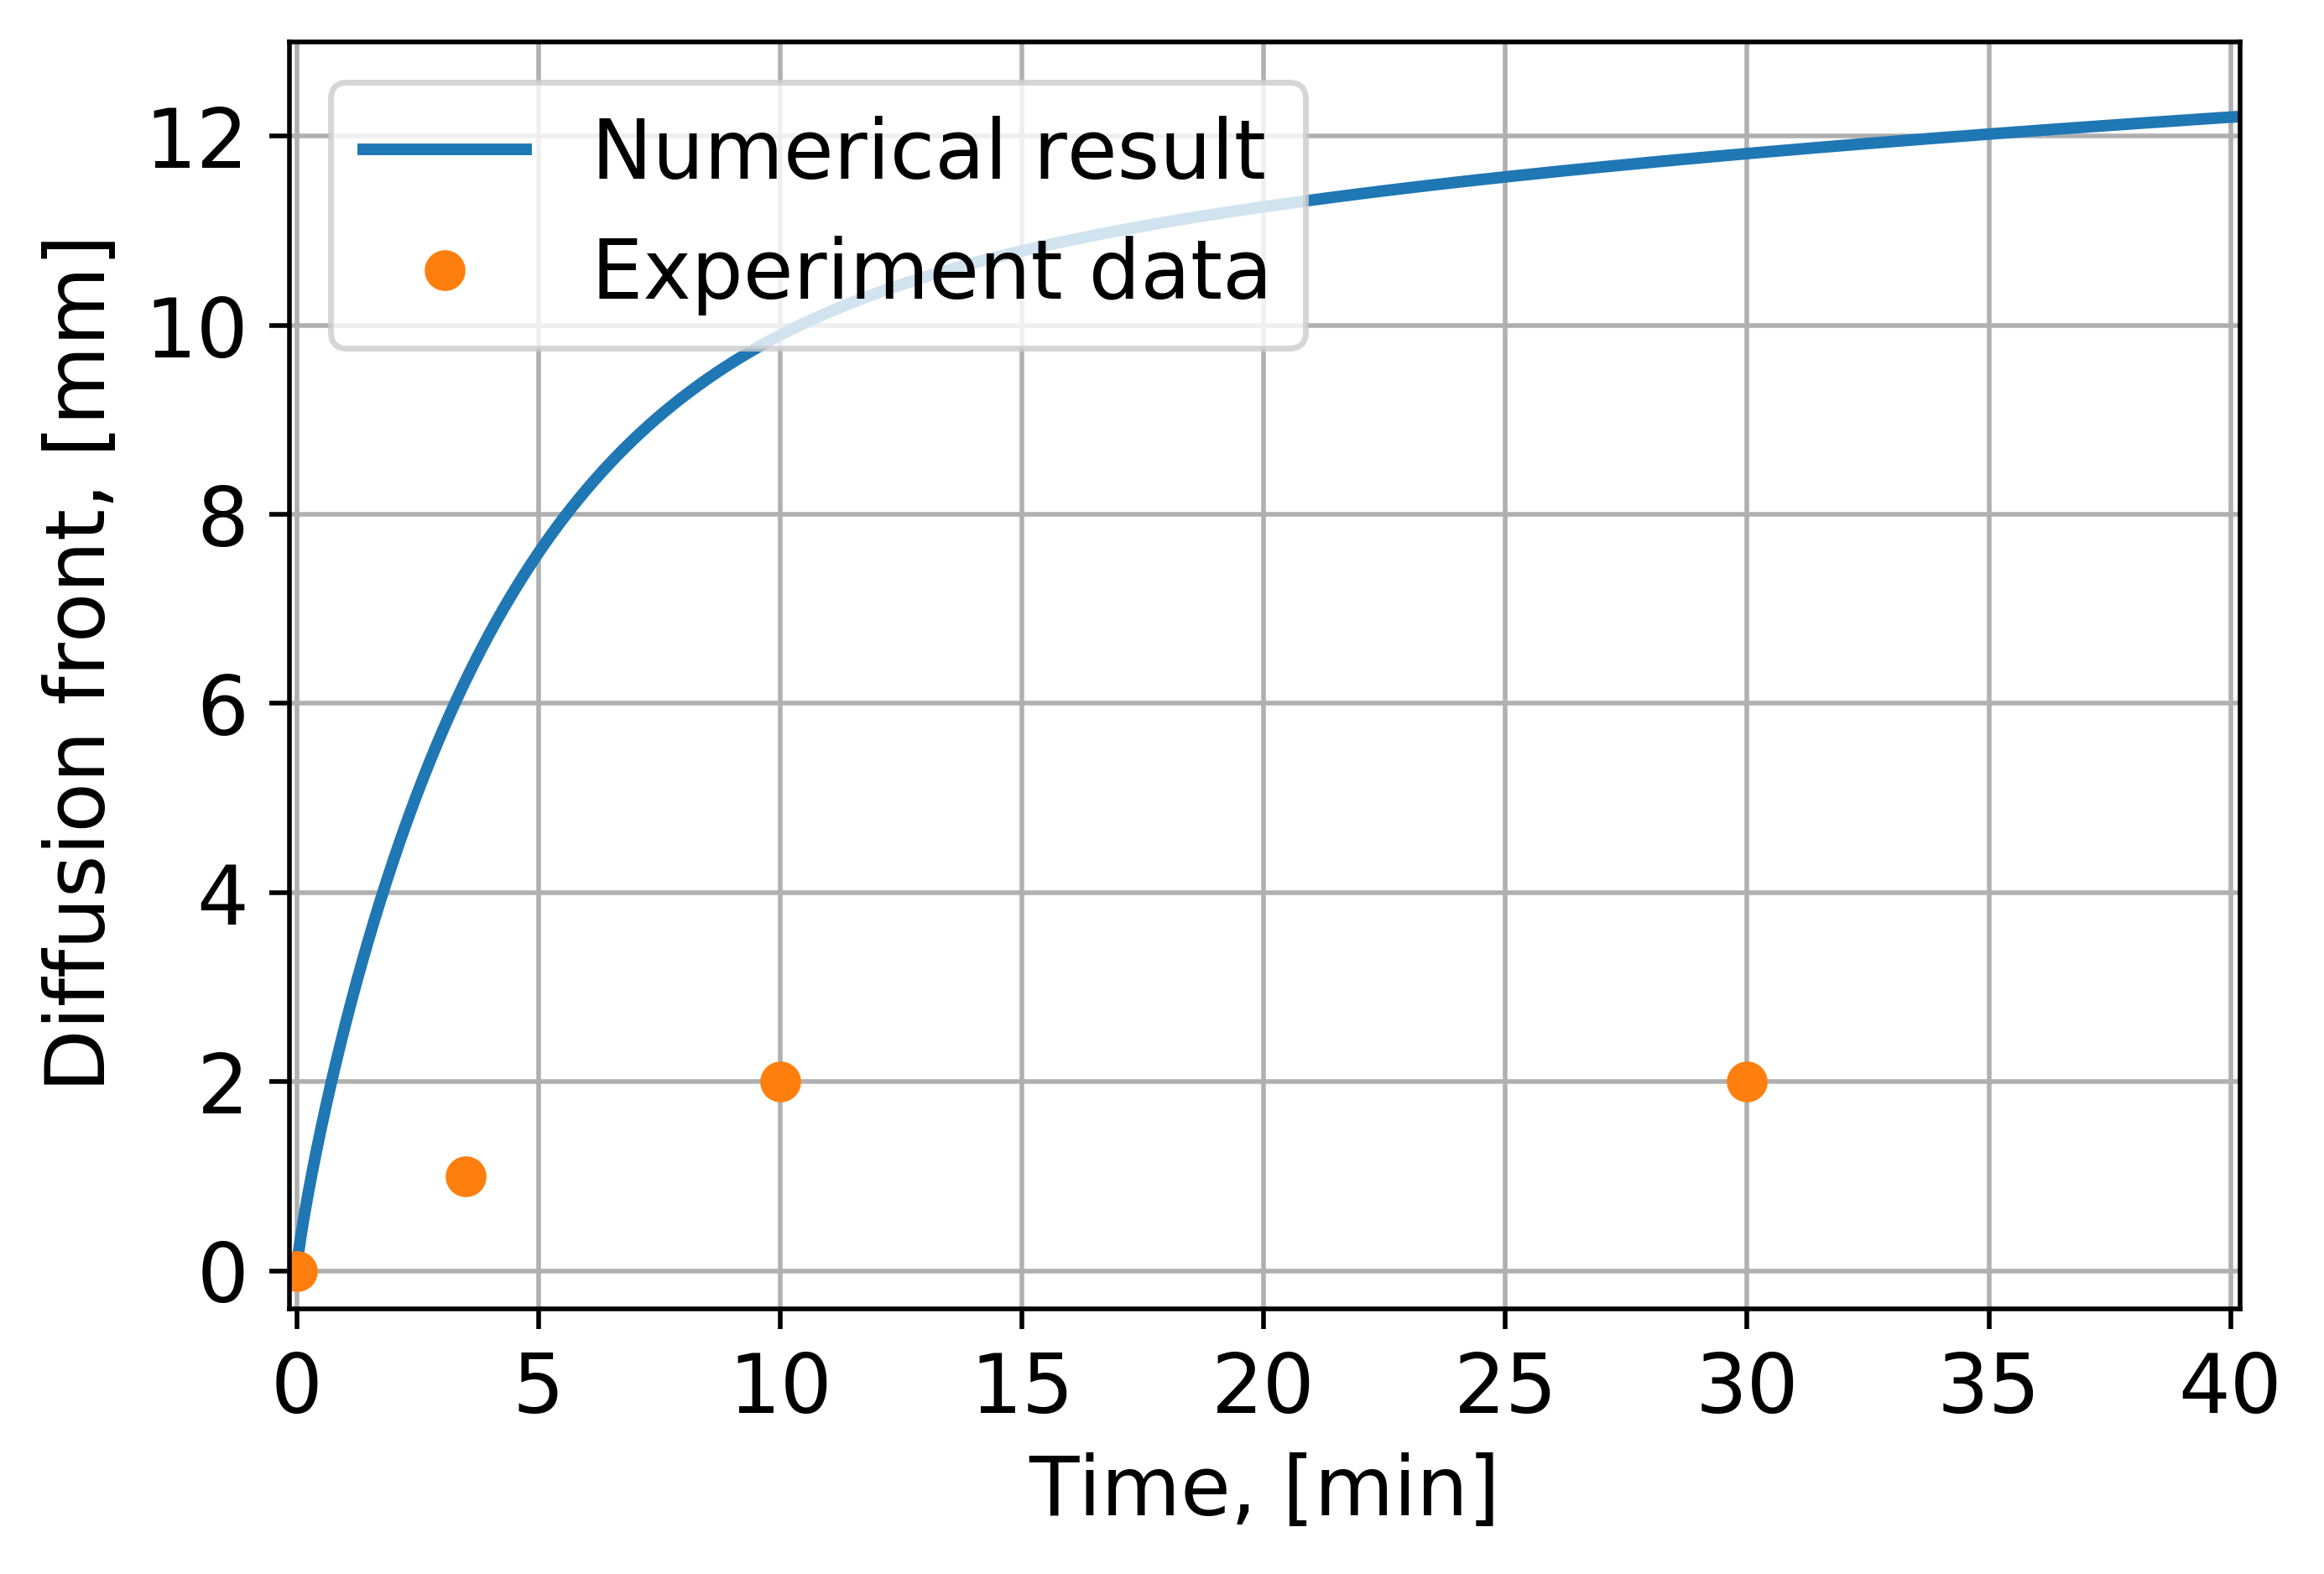

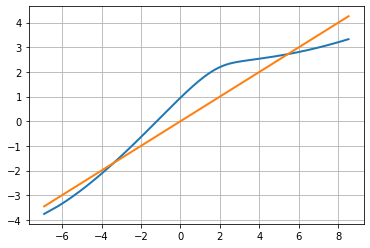

length= 5000000


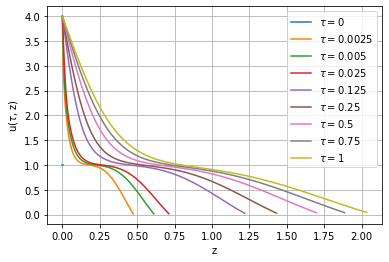

T= [0.0000000e+00 1.0000002e-03 2.0000004e-03 ... 4.9999980e+03 4.9999990e+03
 5.0000000e+03]


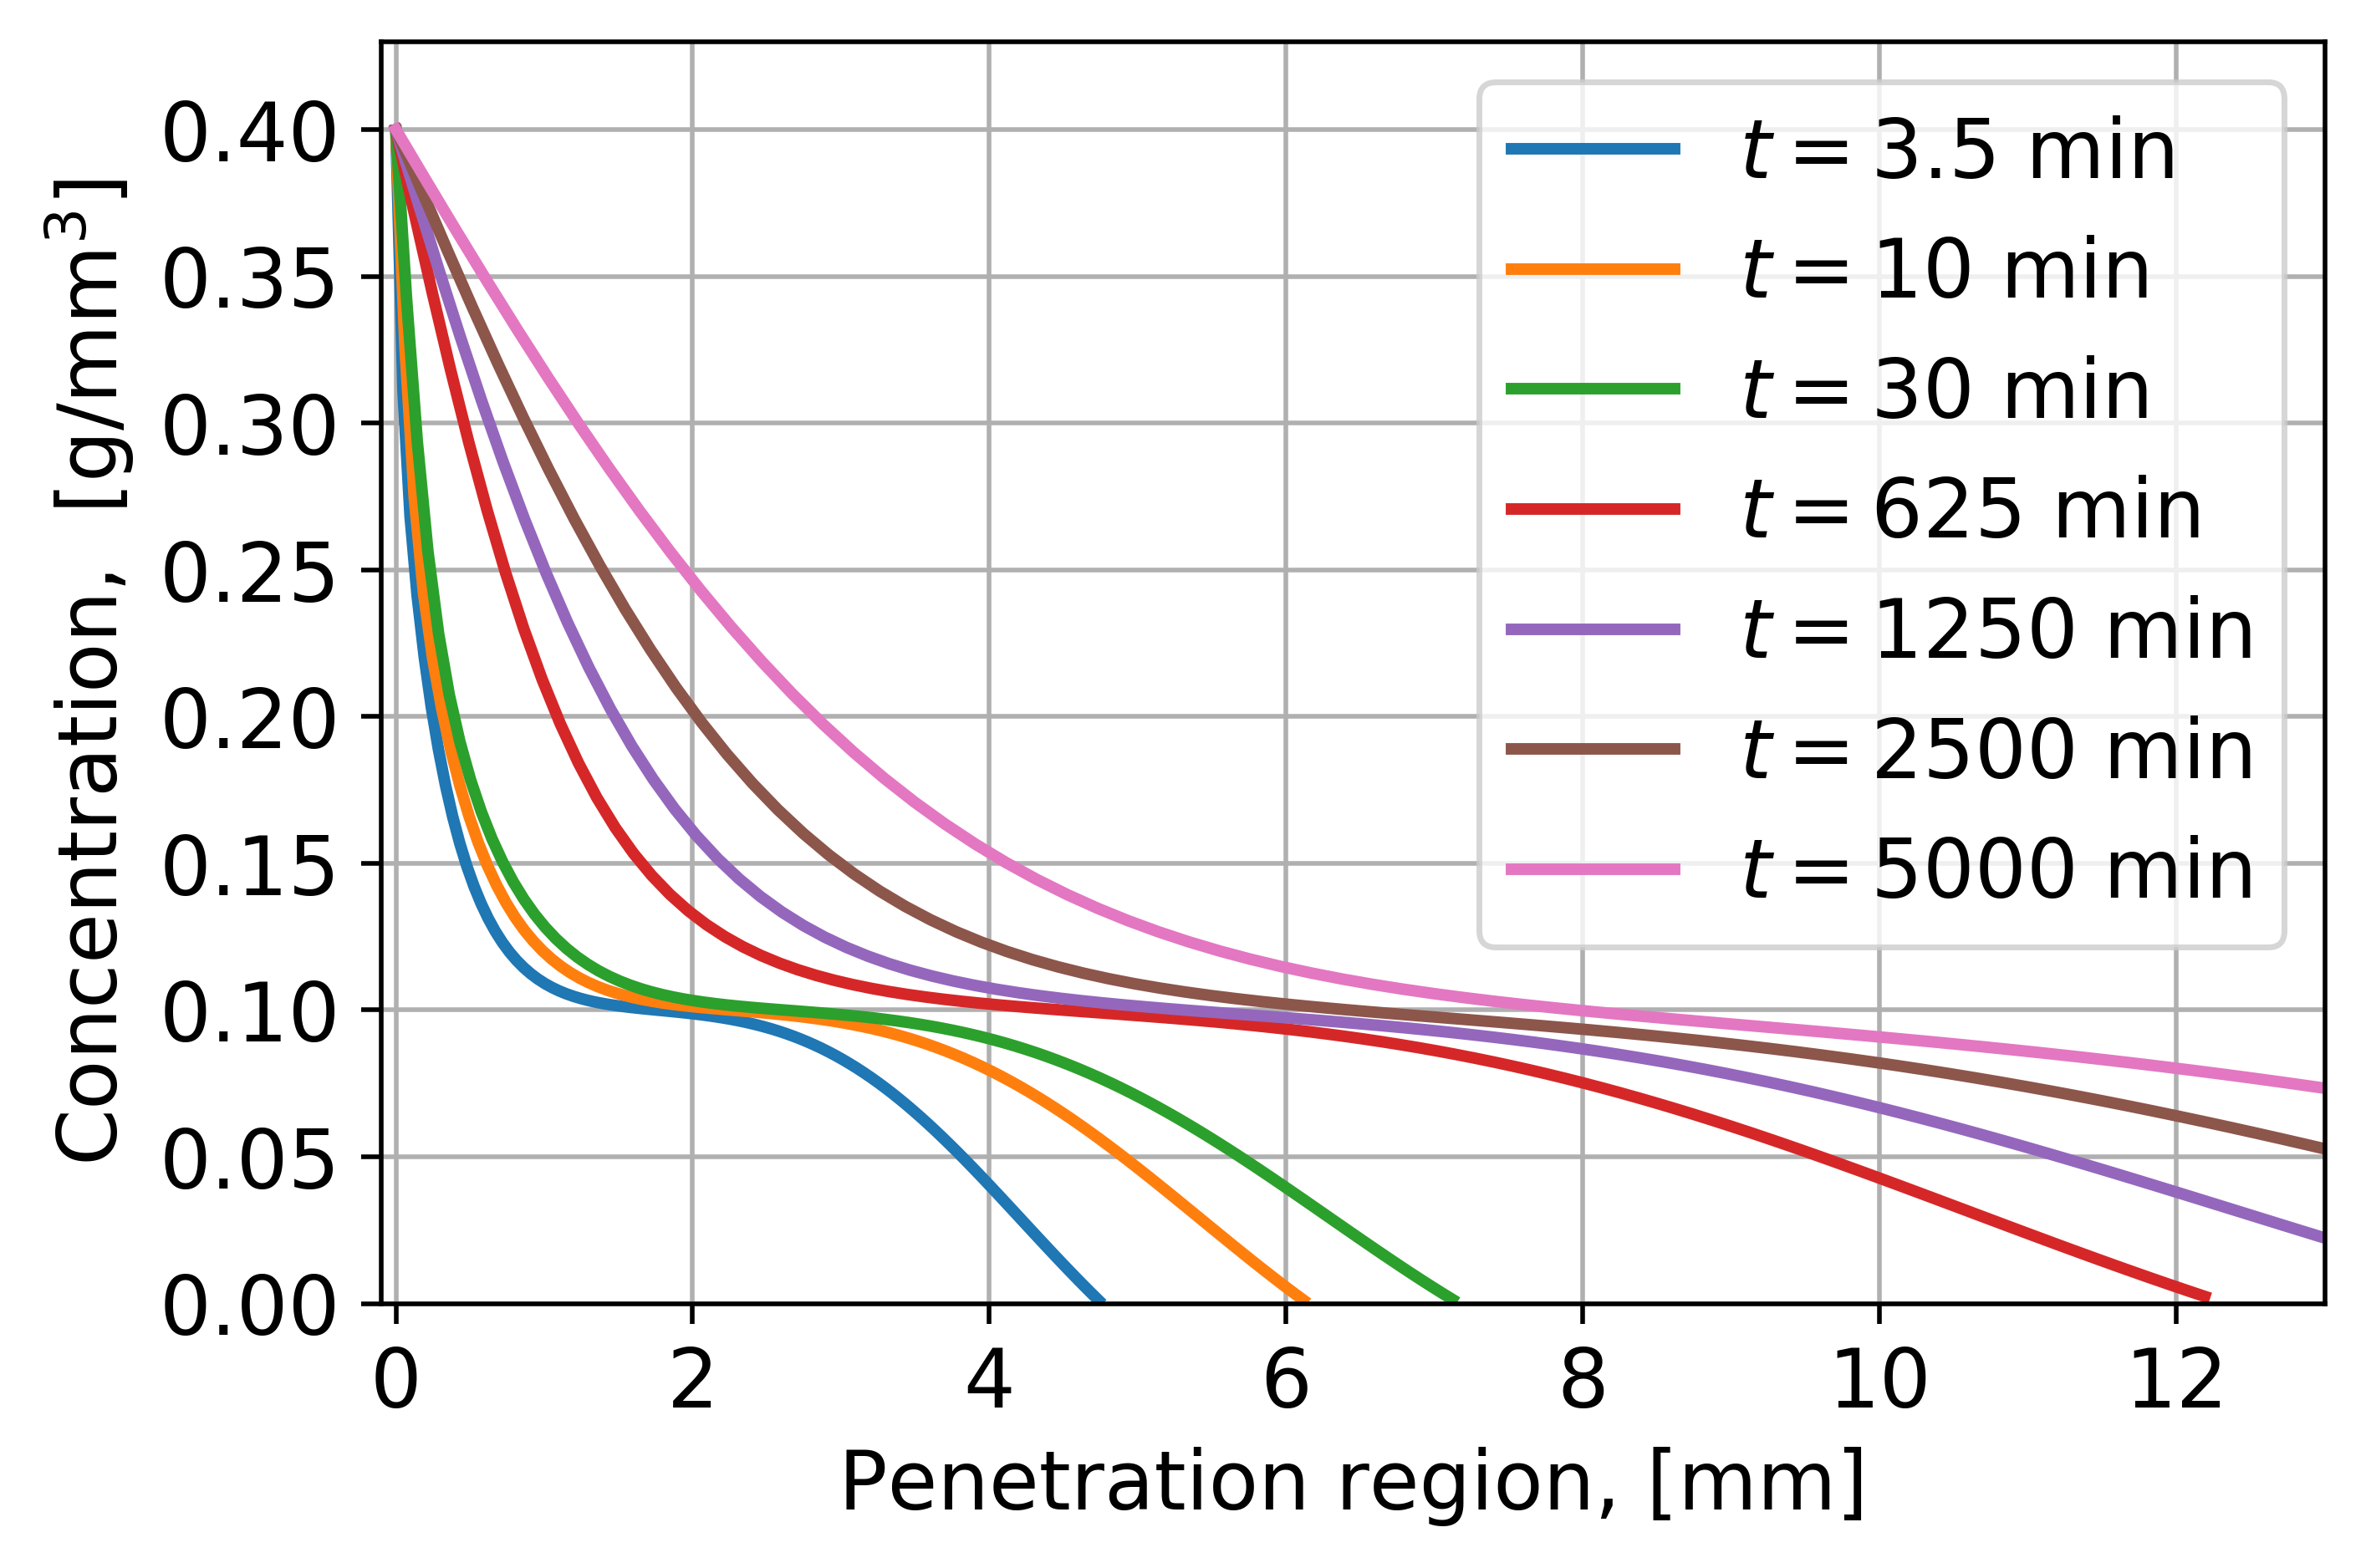

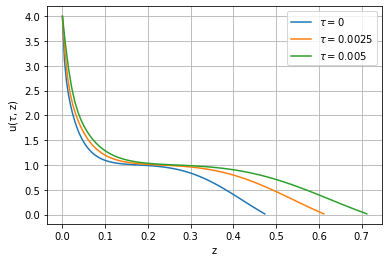

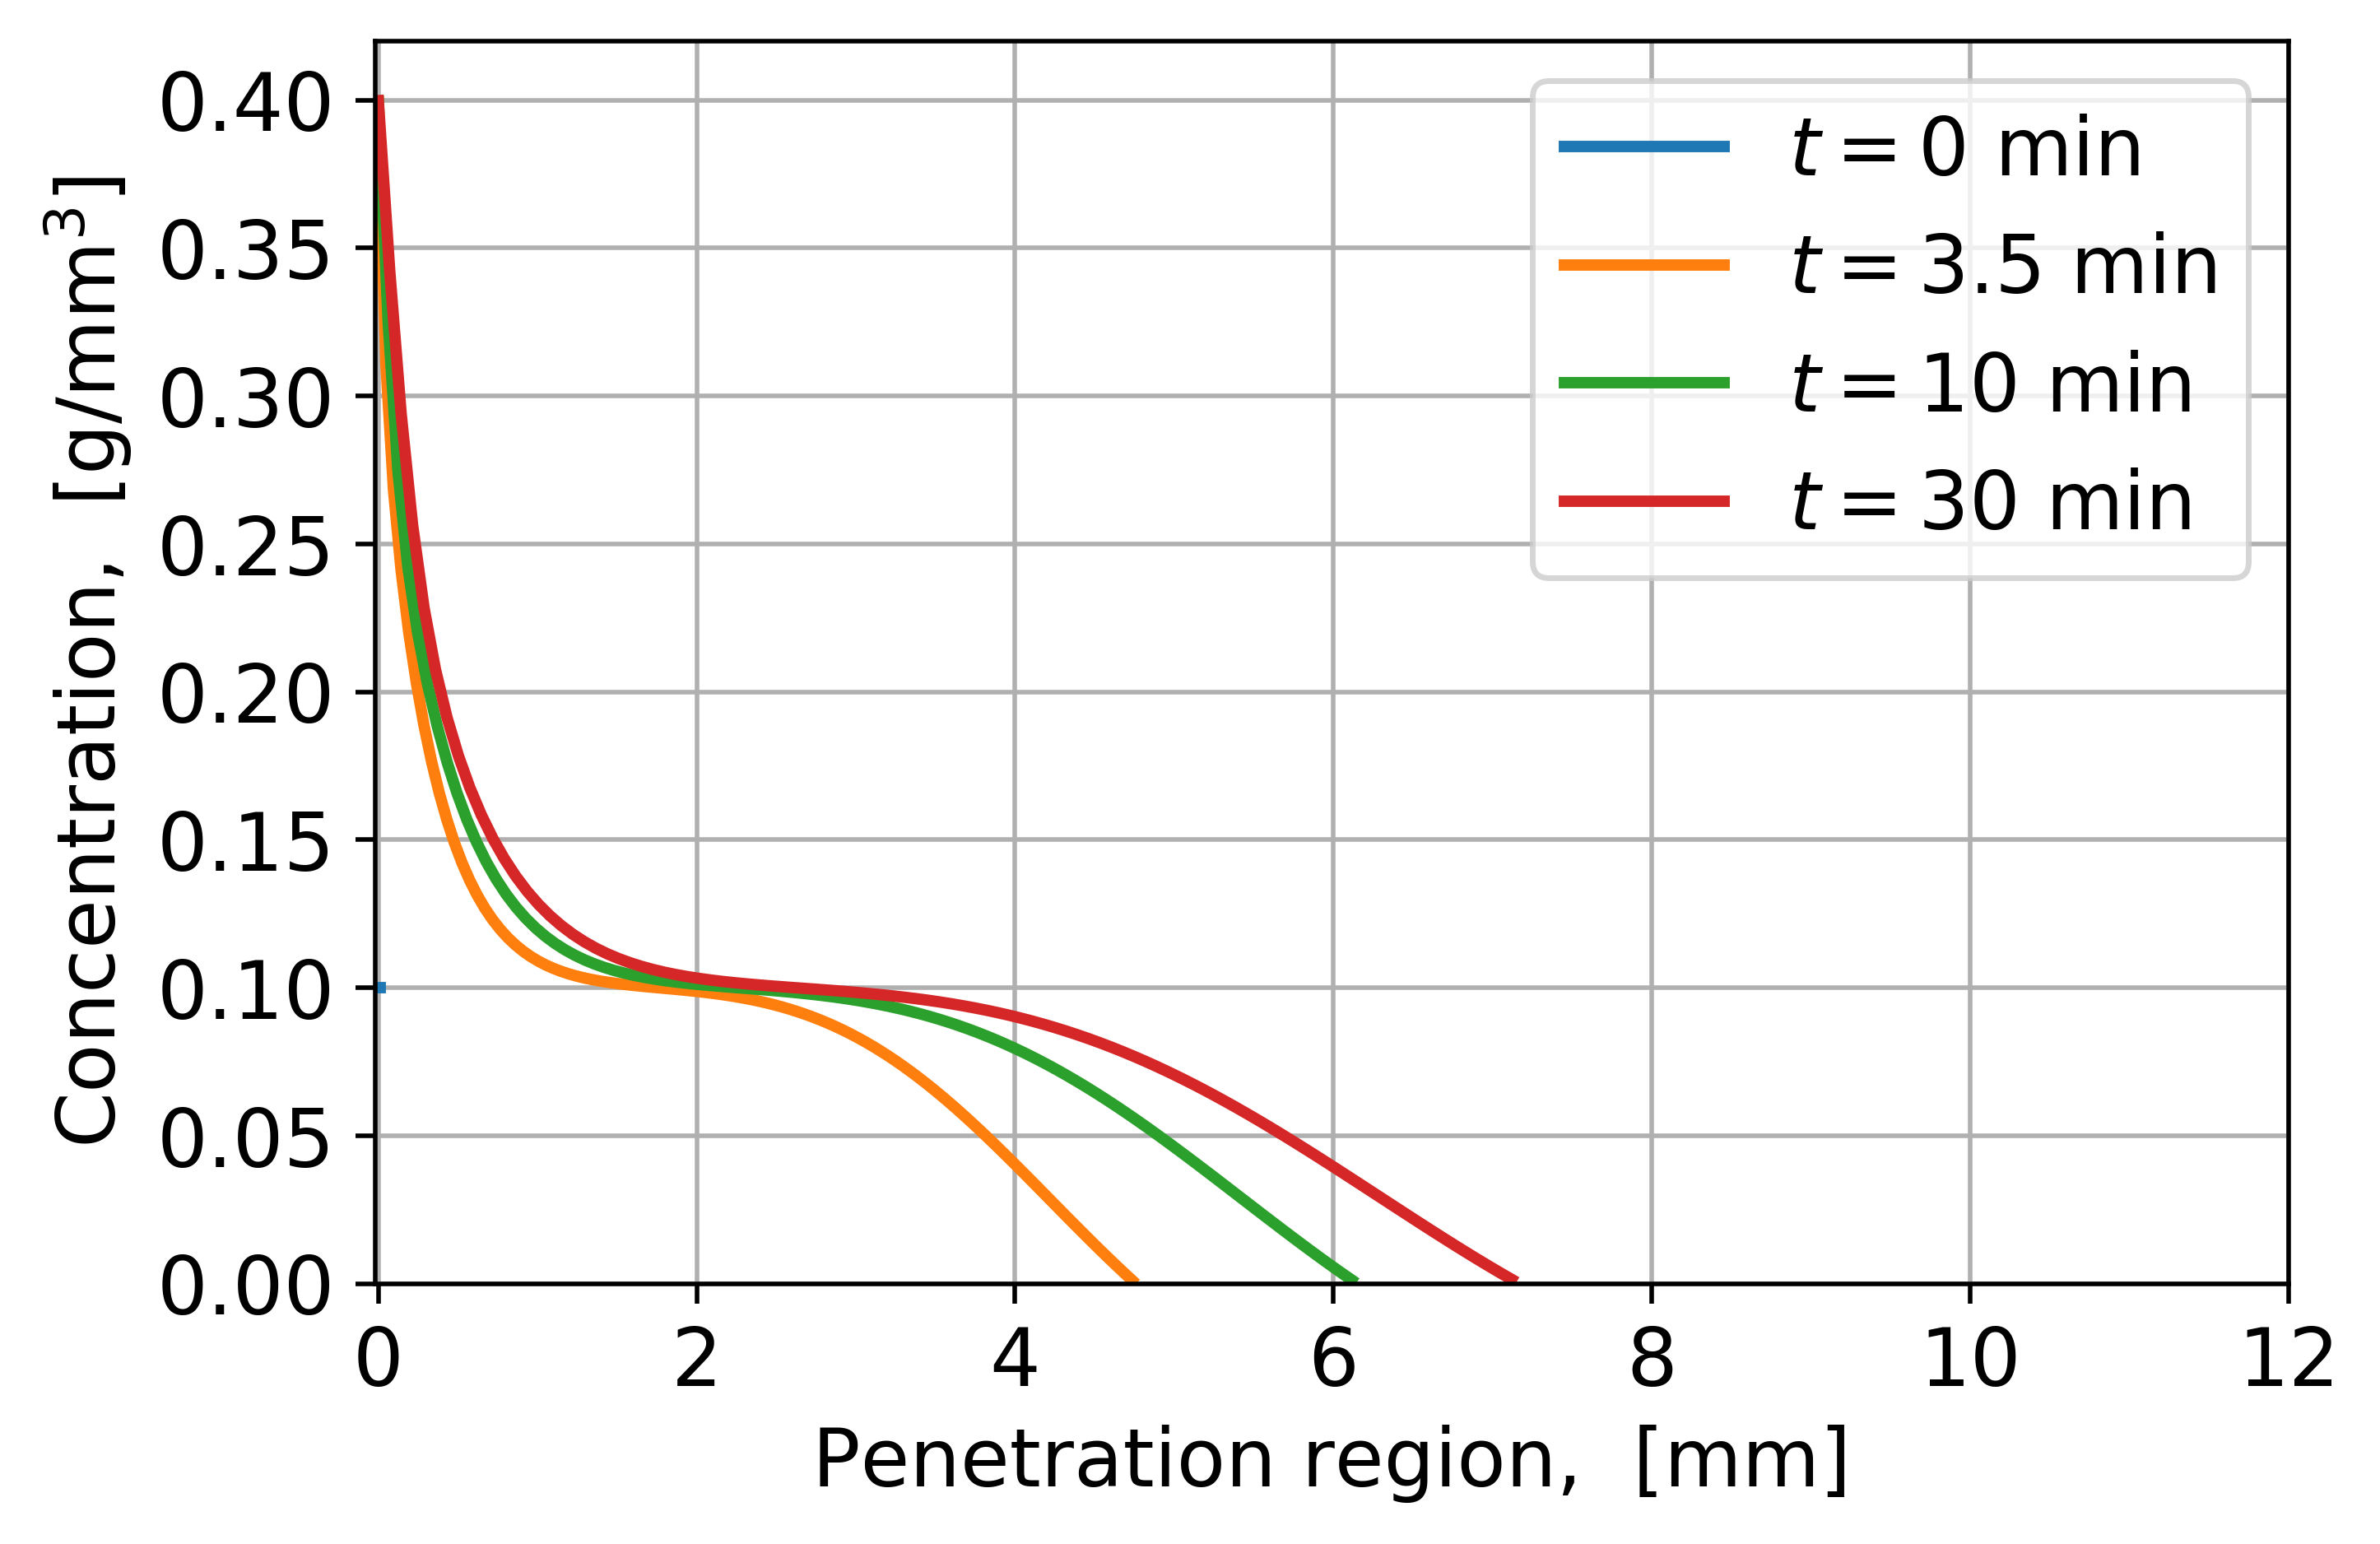

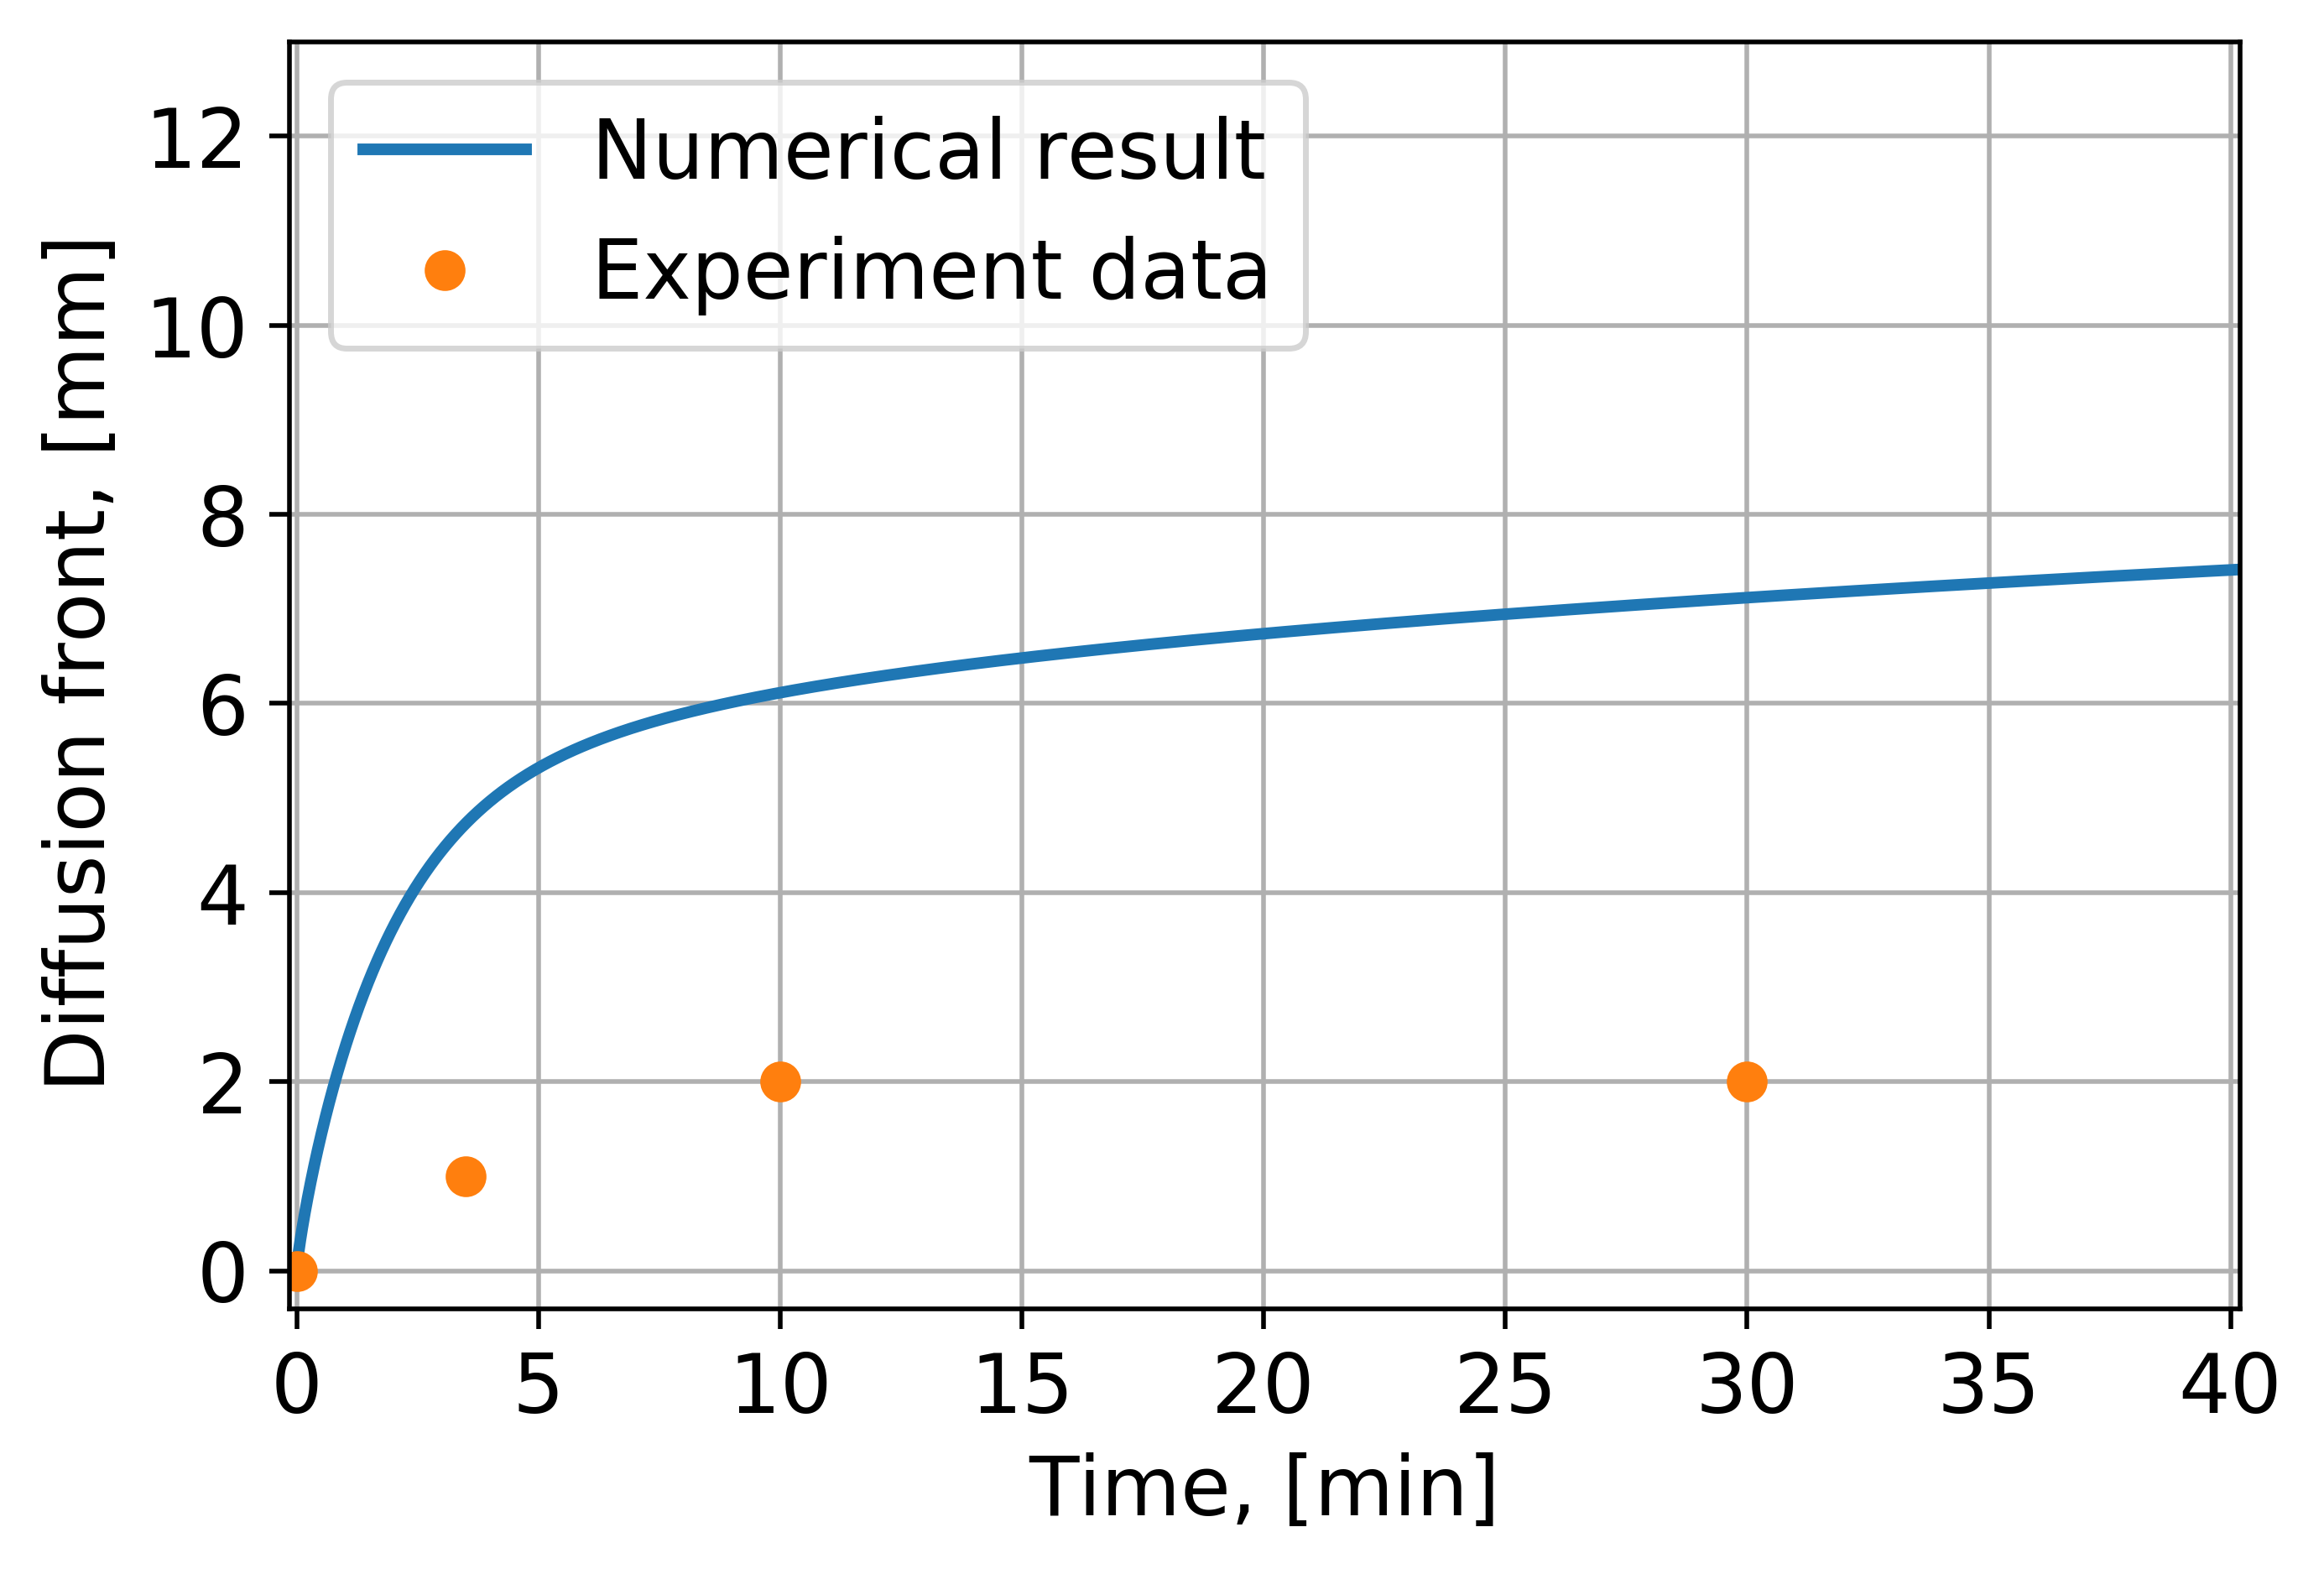

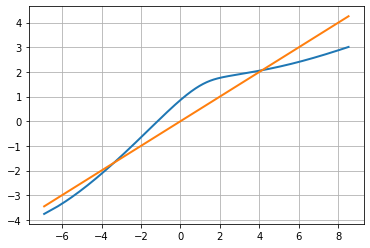

length= 5000000


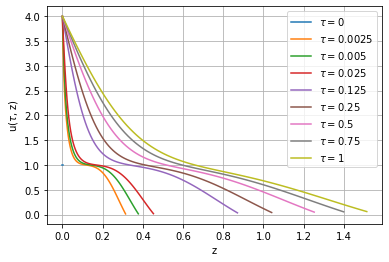

T= [0.0000000e+00 1.0000002e-03 2.0000004e-03 ... 4.9999980e+03 4.9999990e+03
 5.0000000e+03]


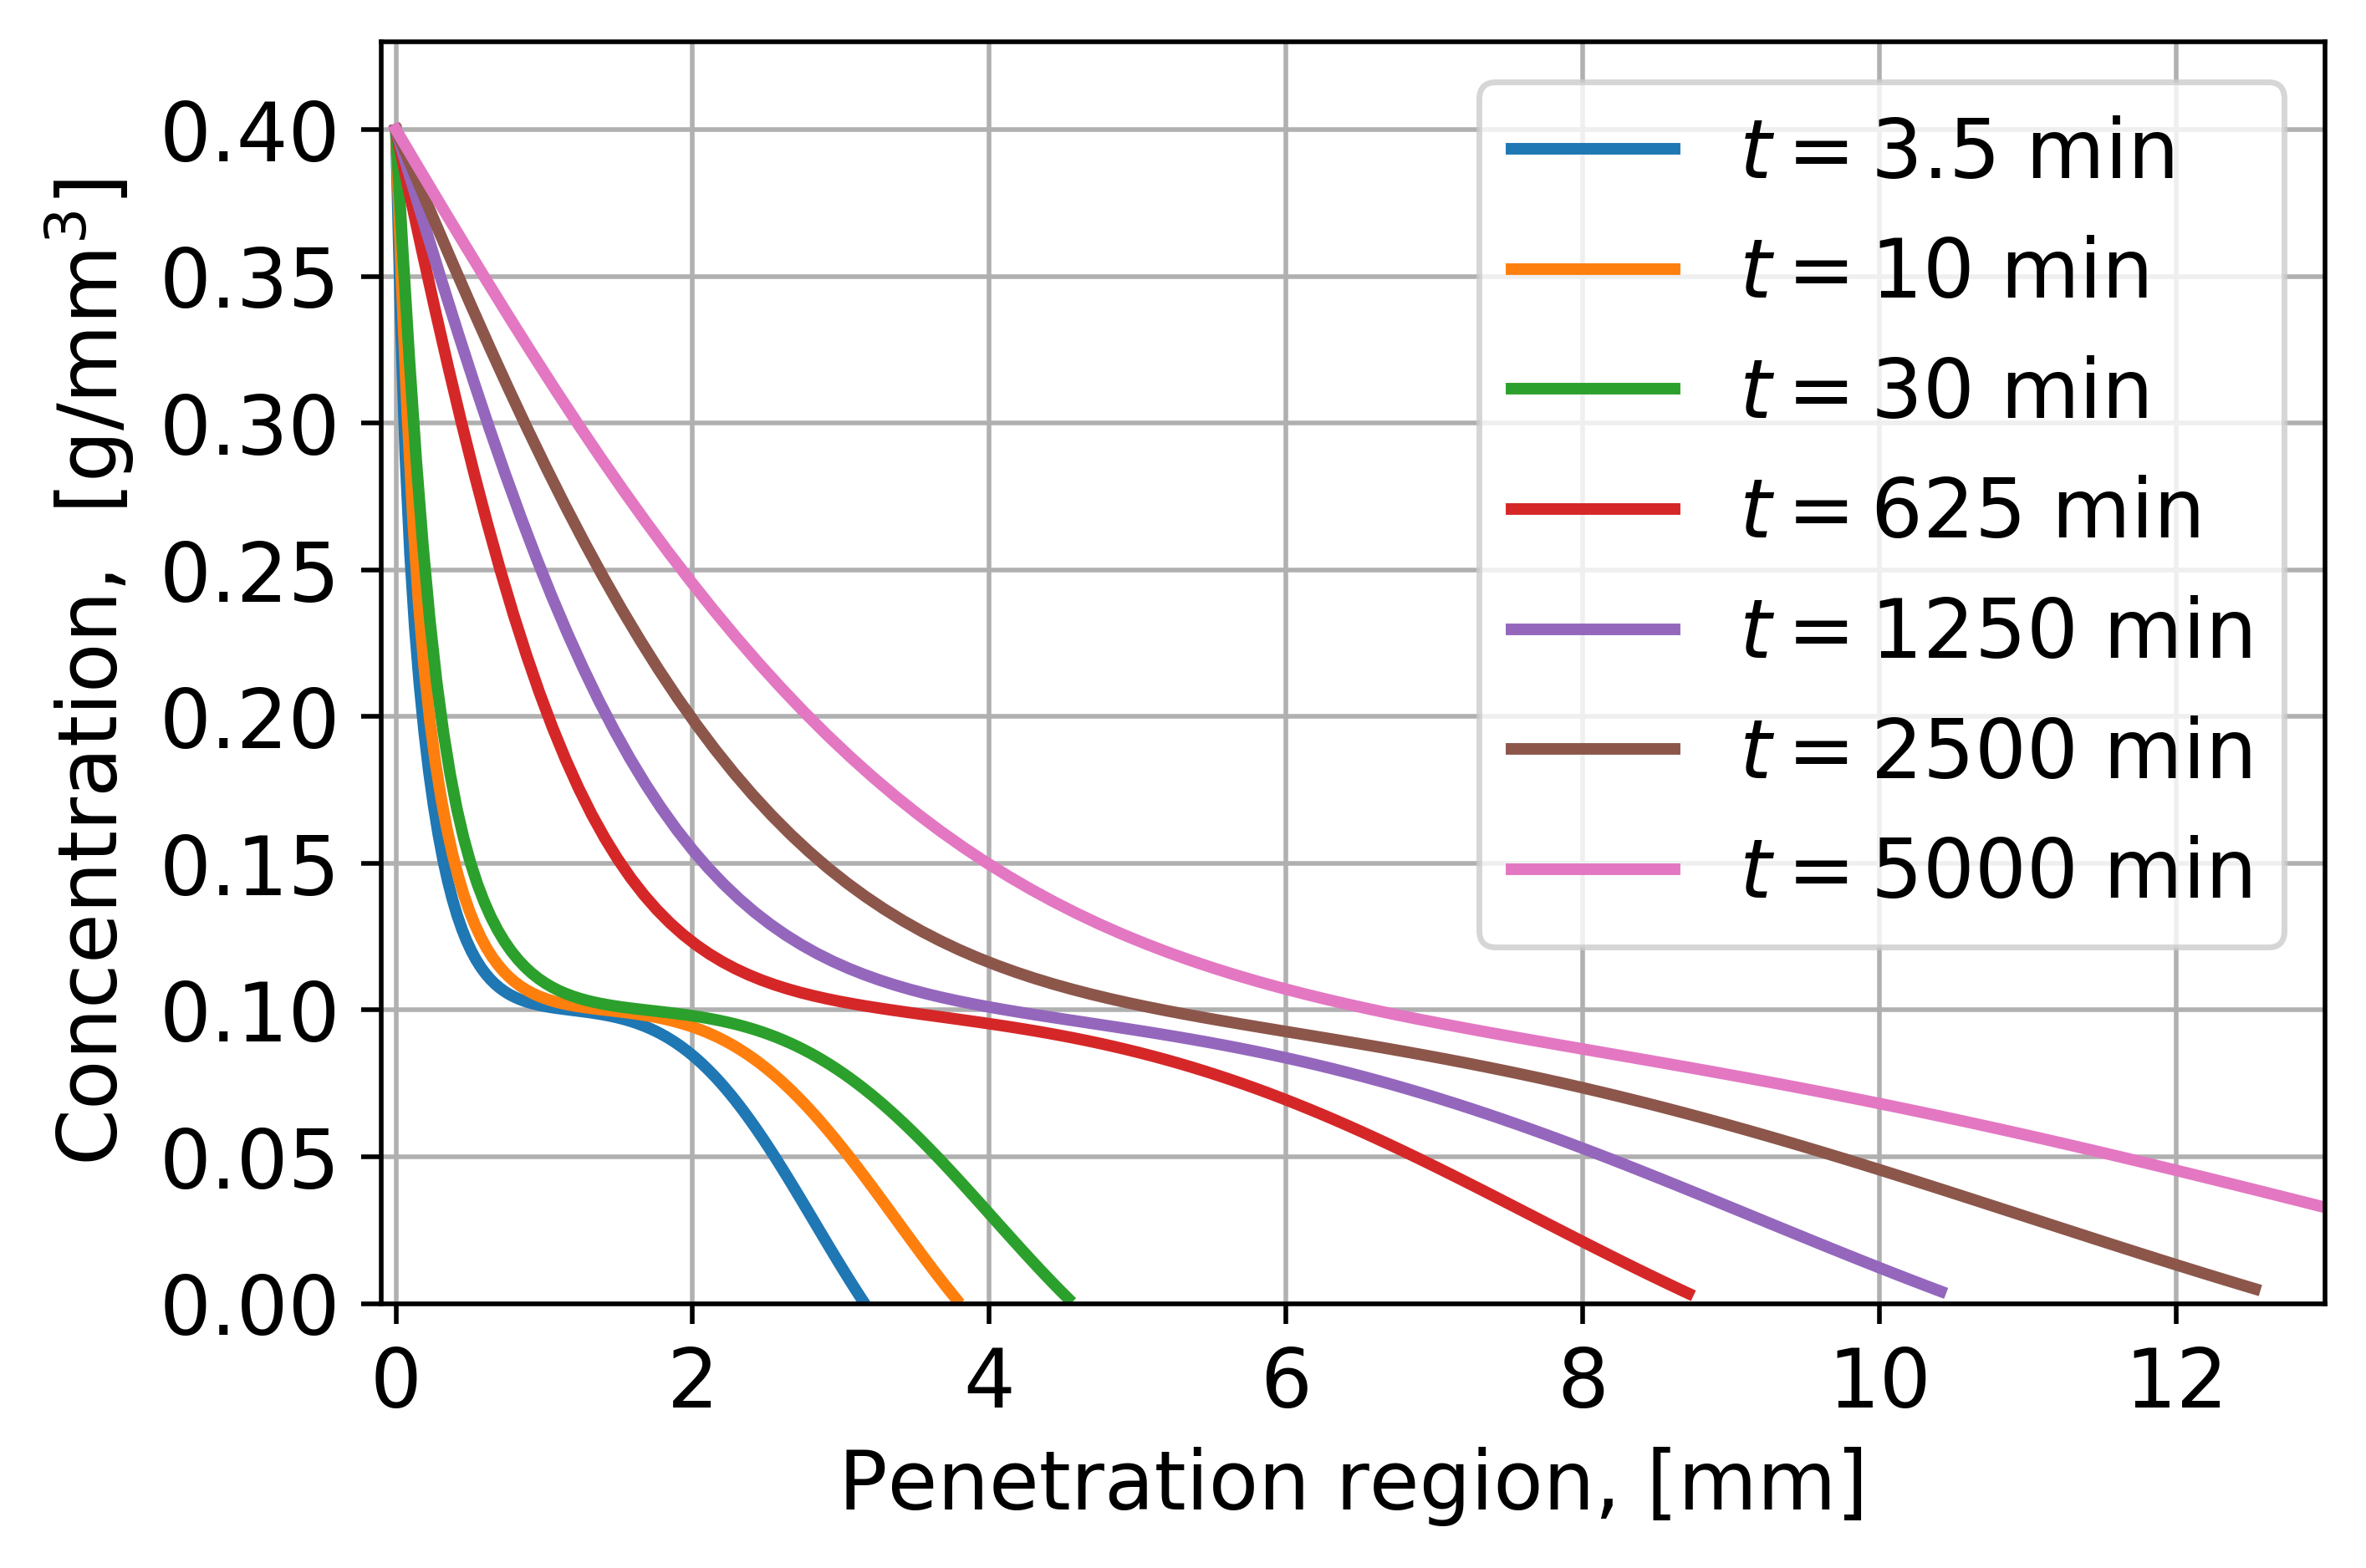

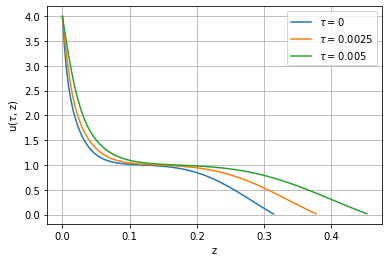

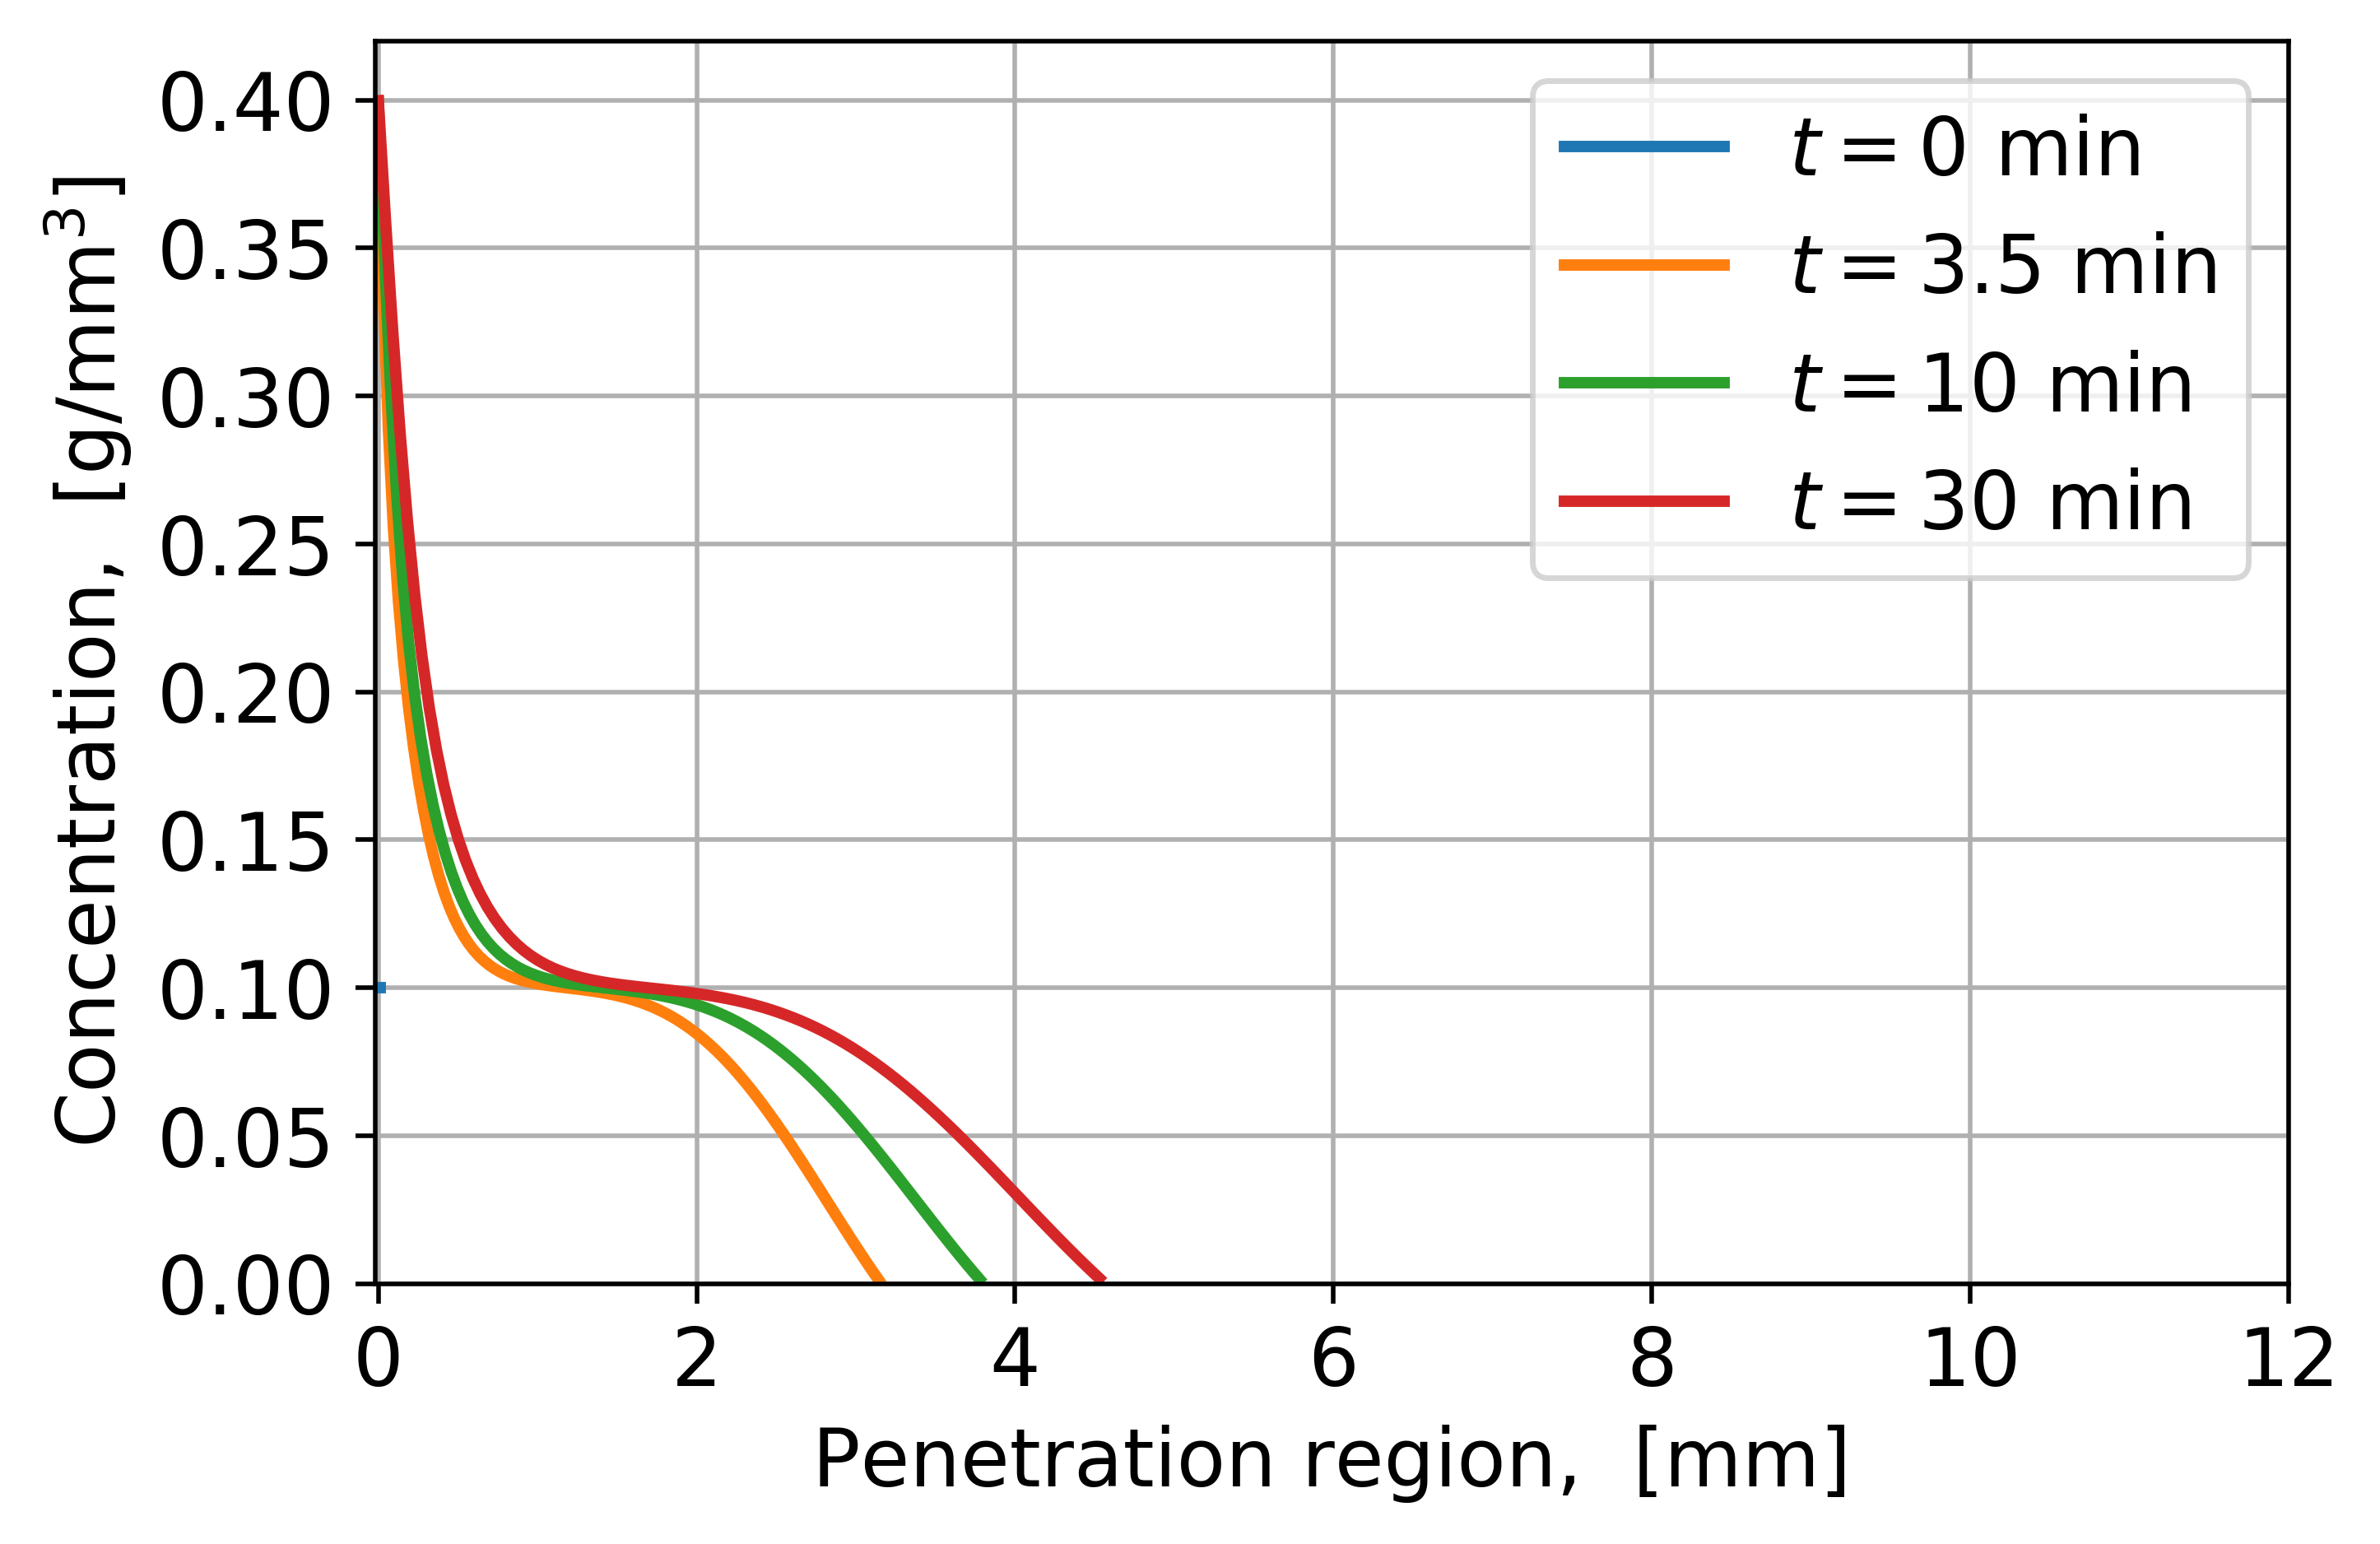

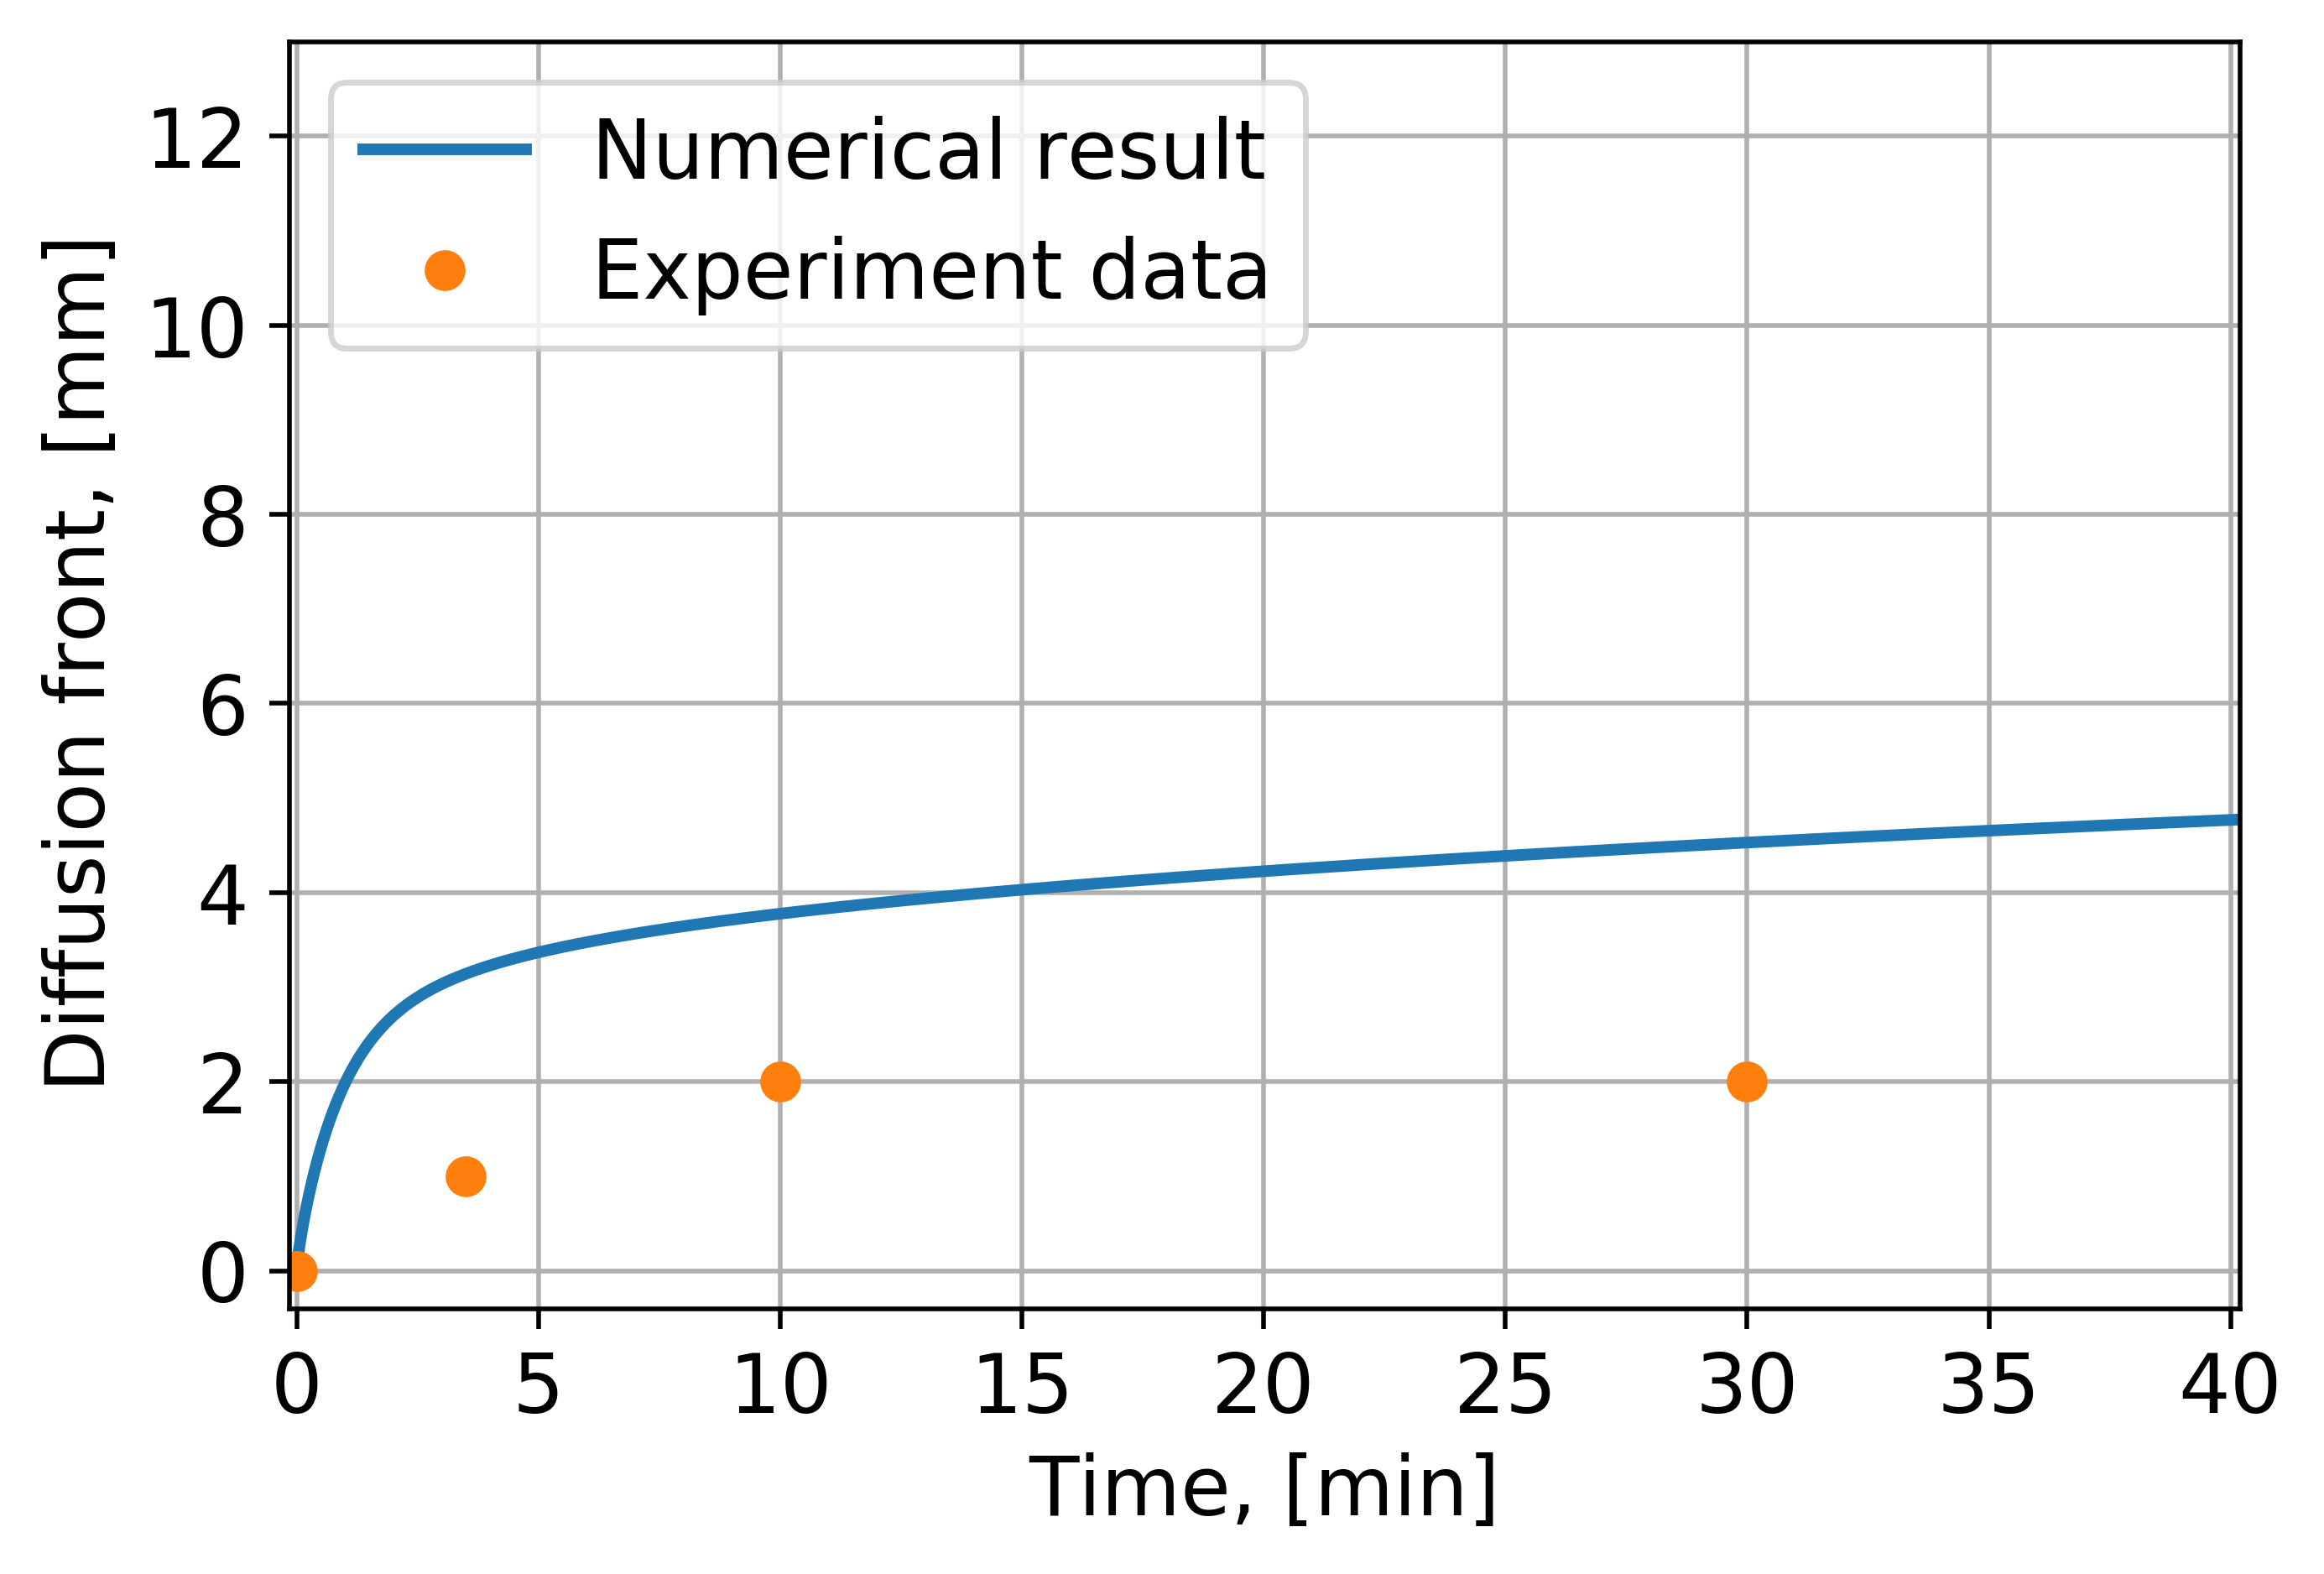

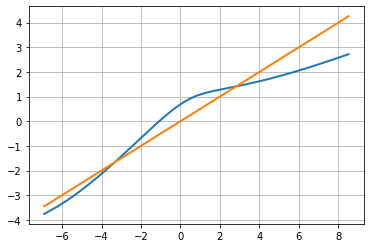

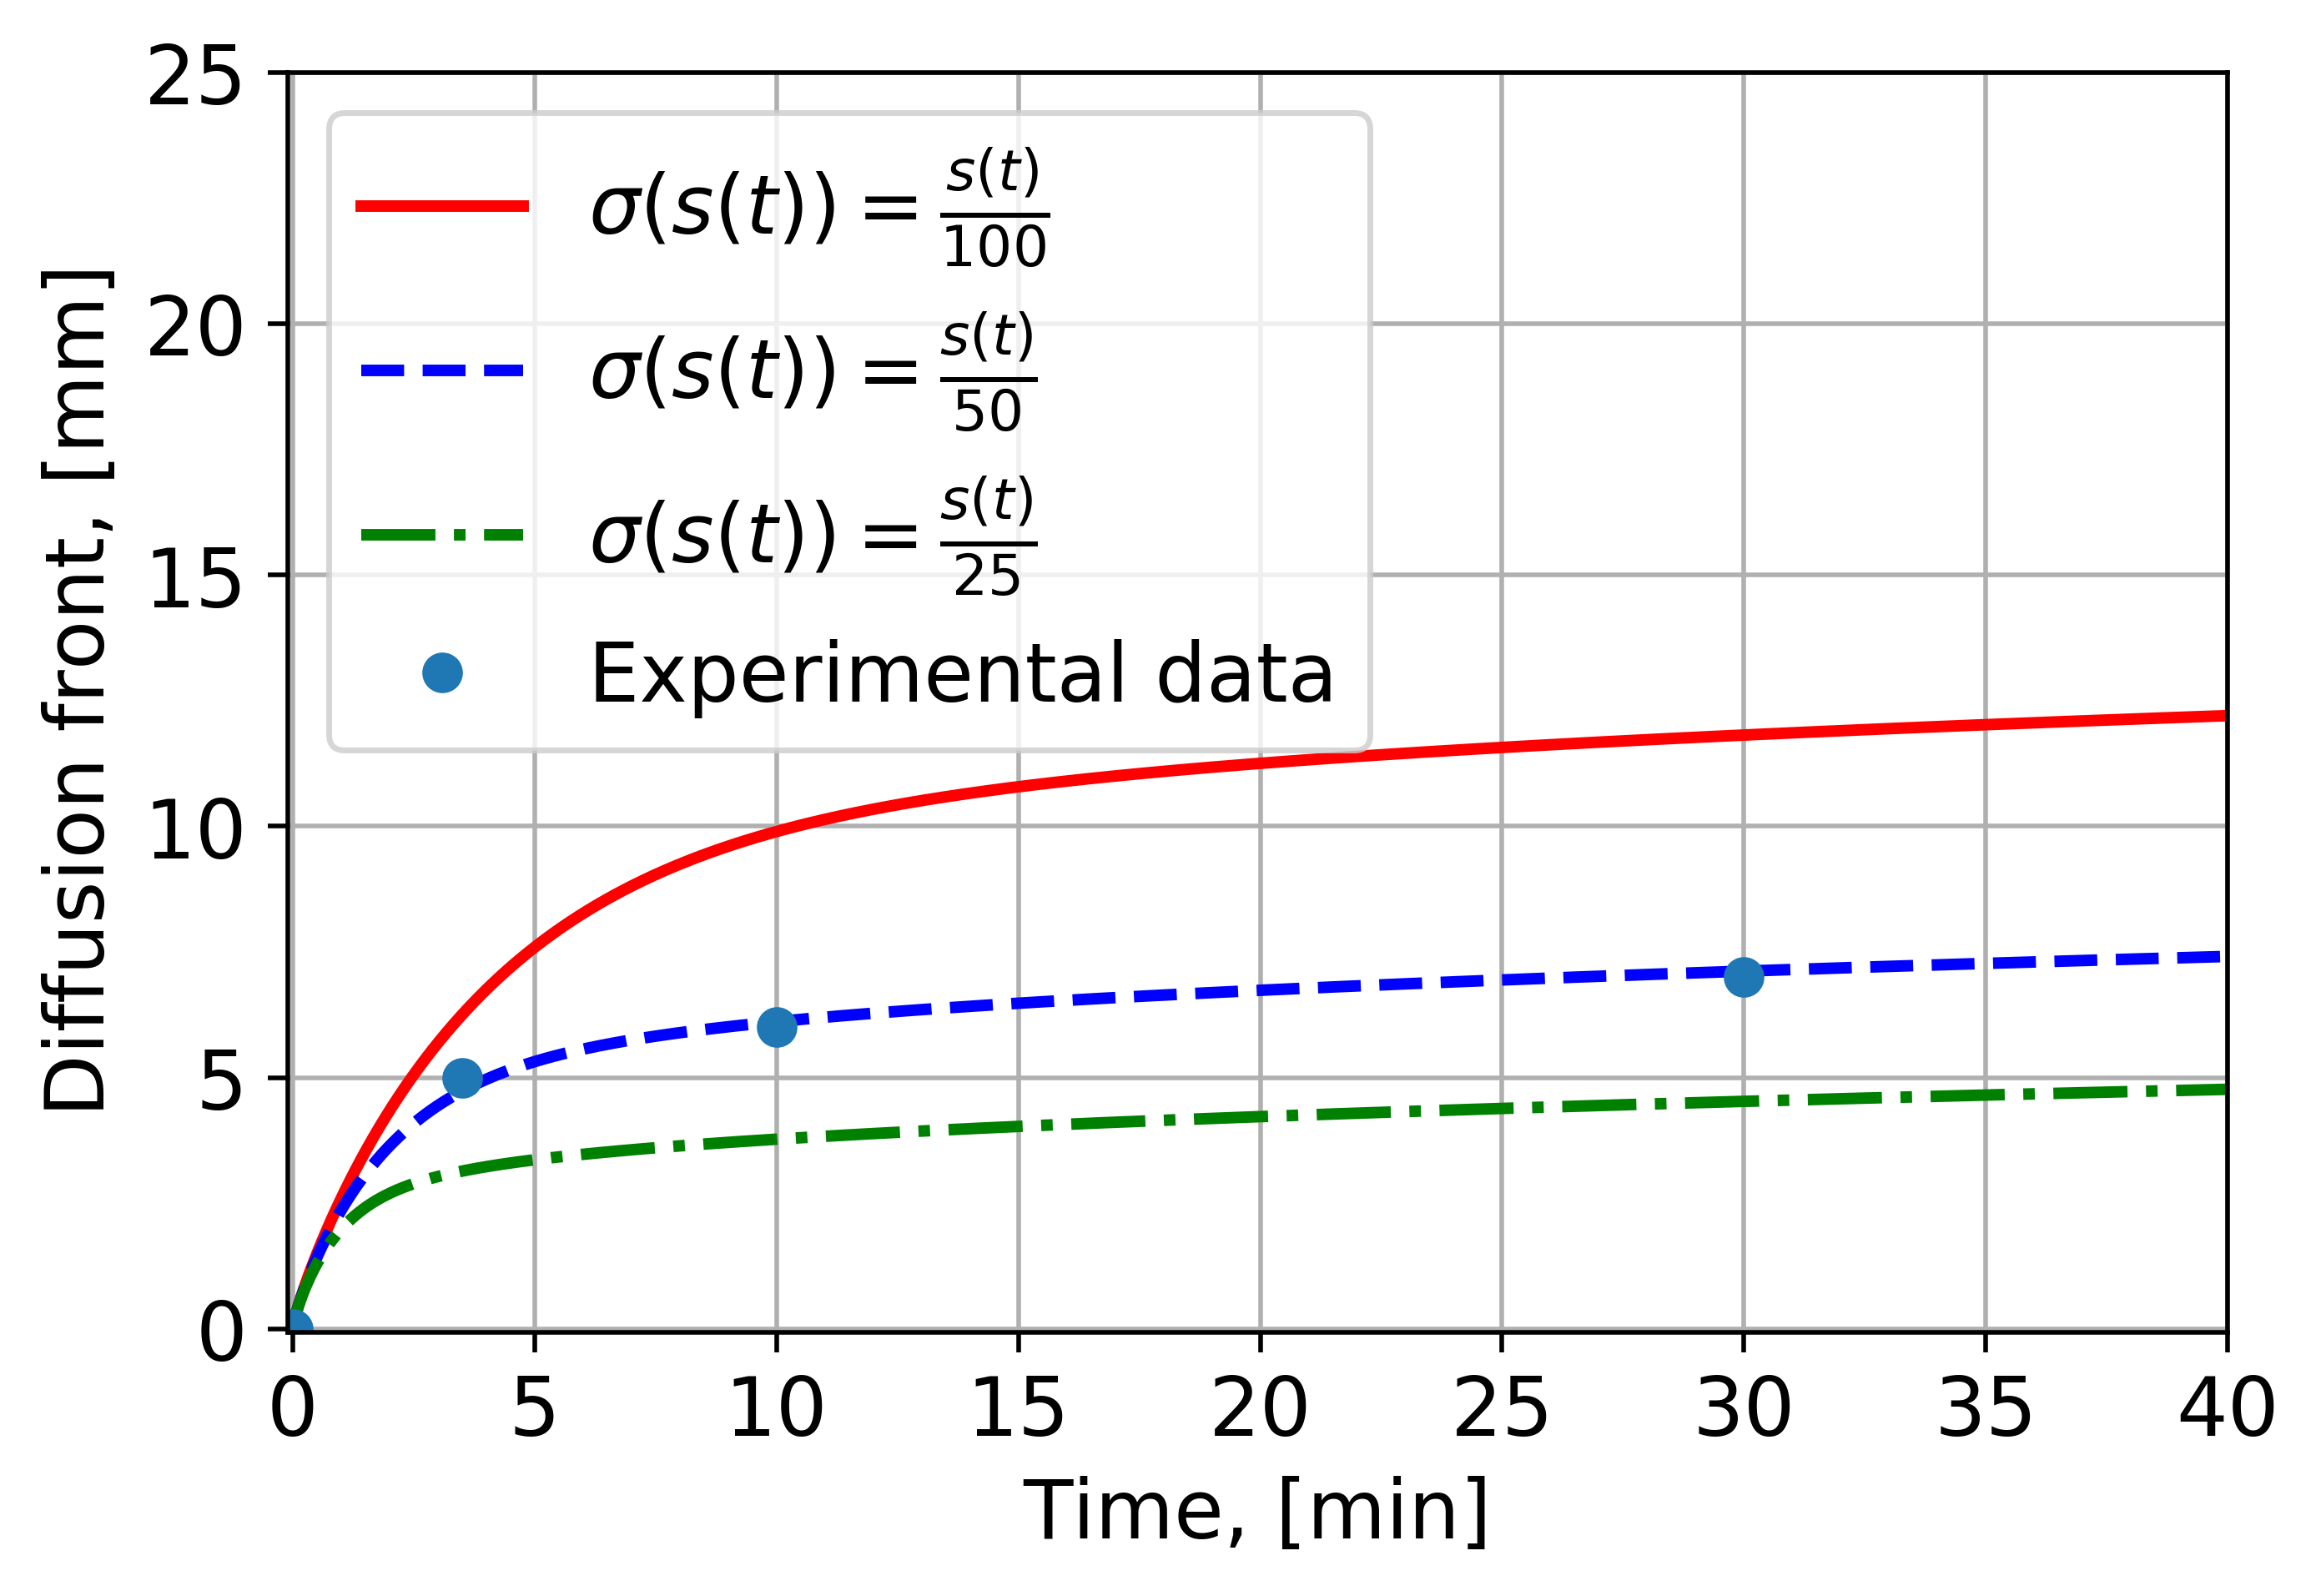

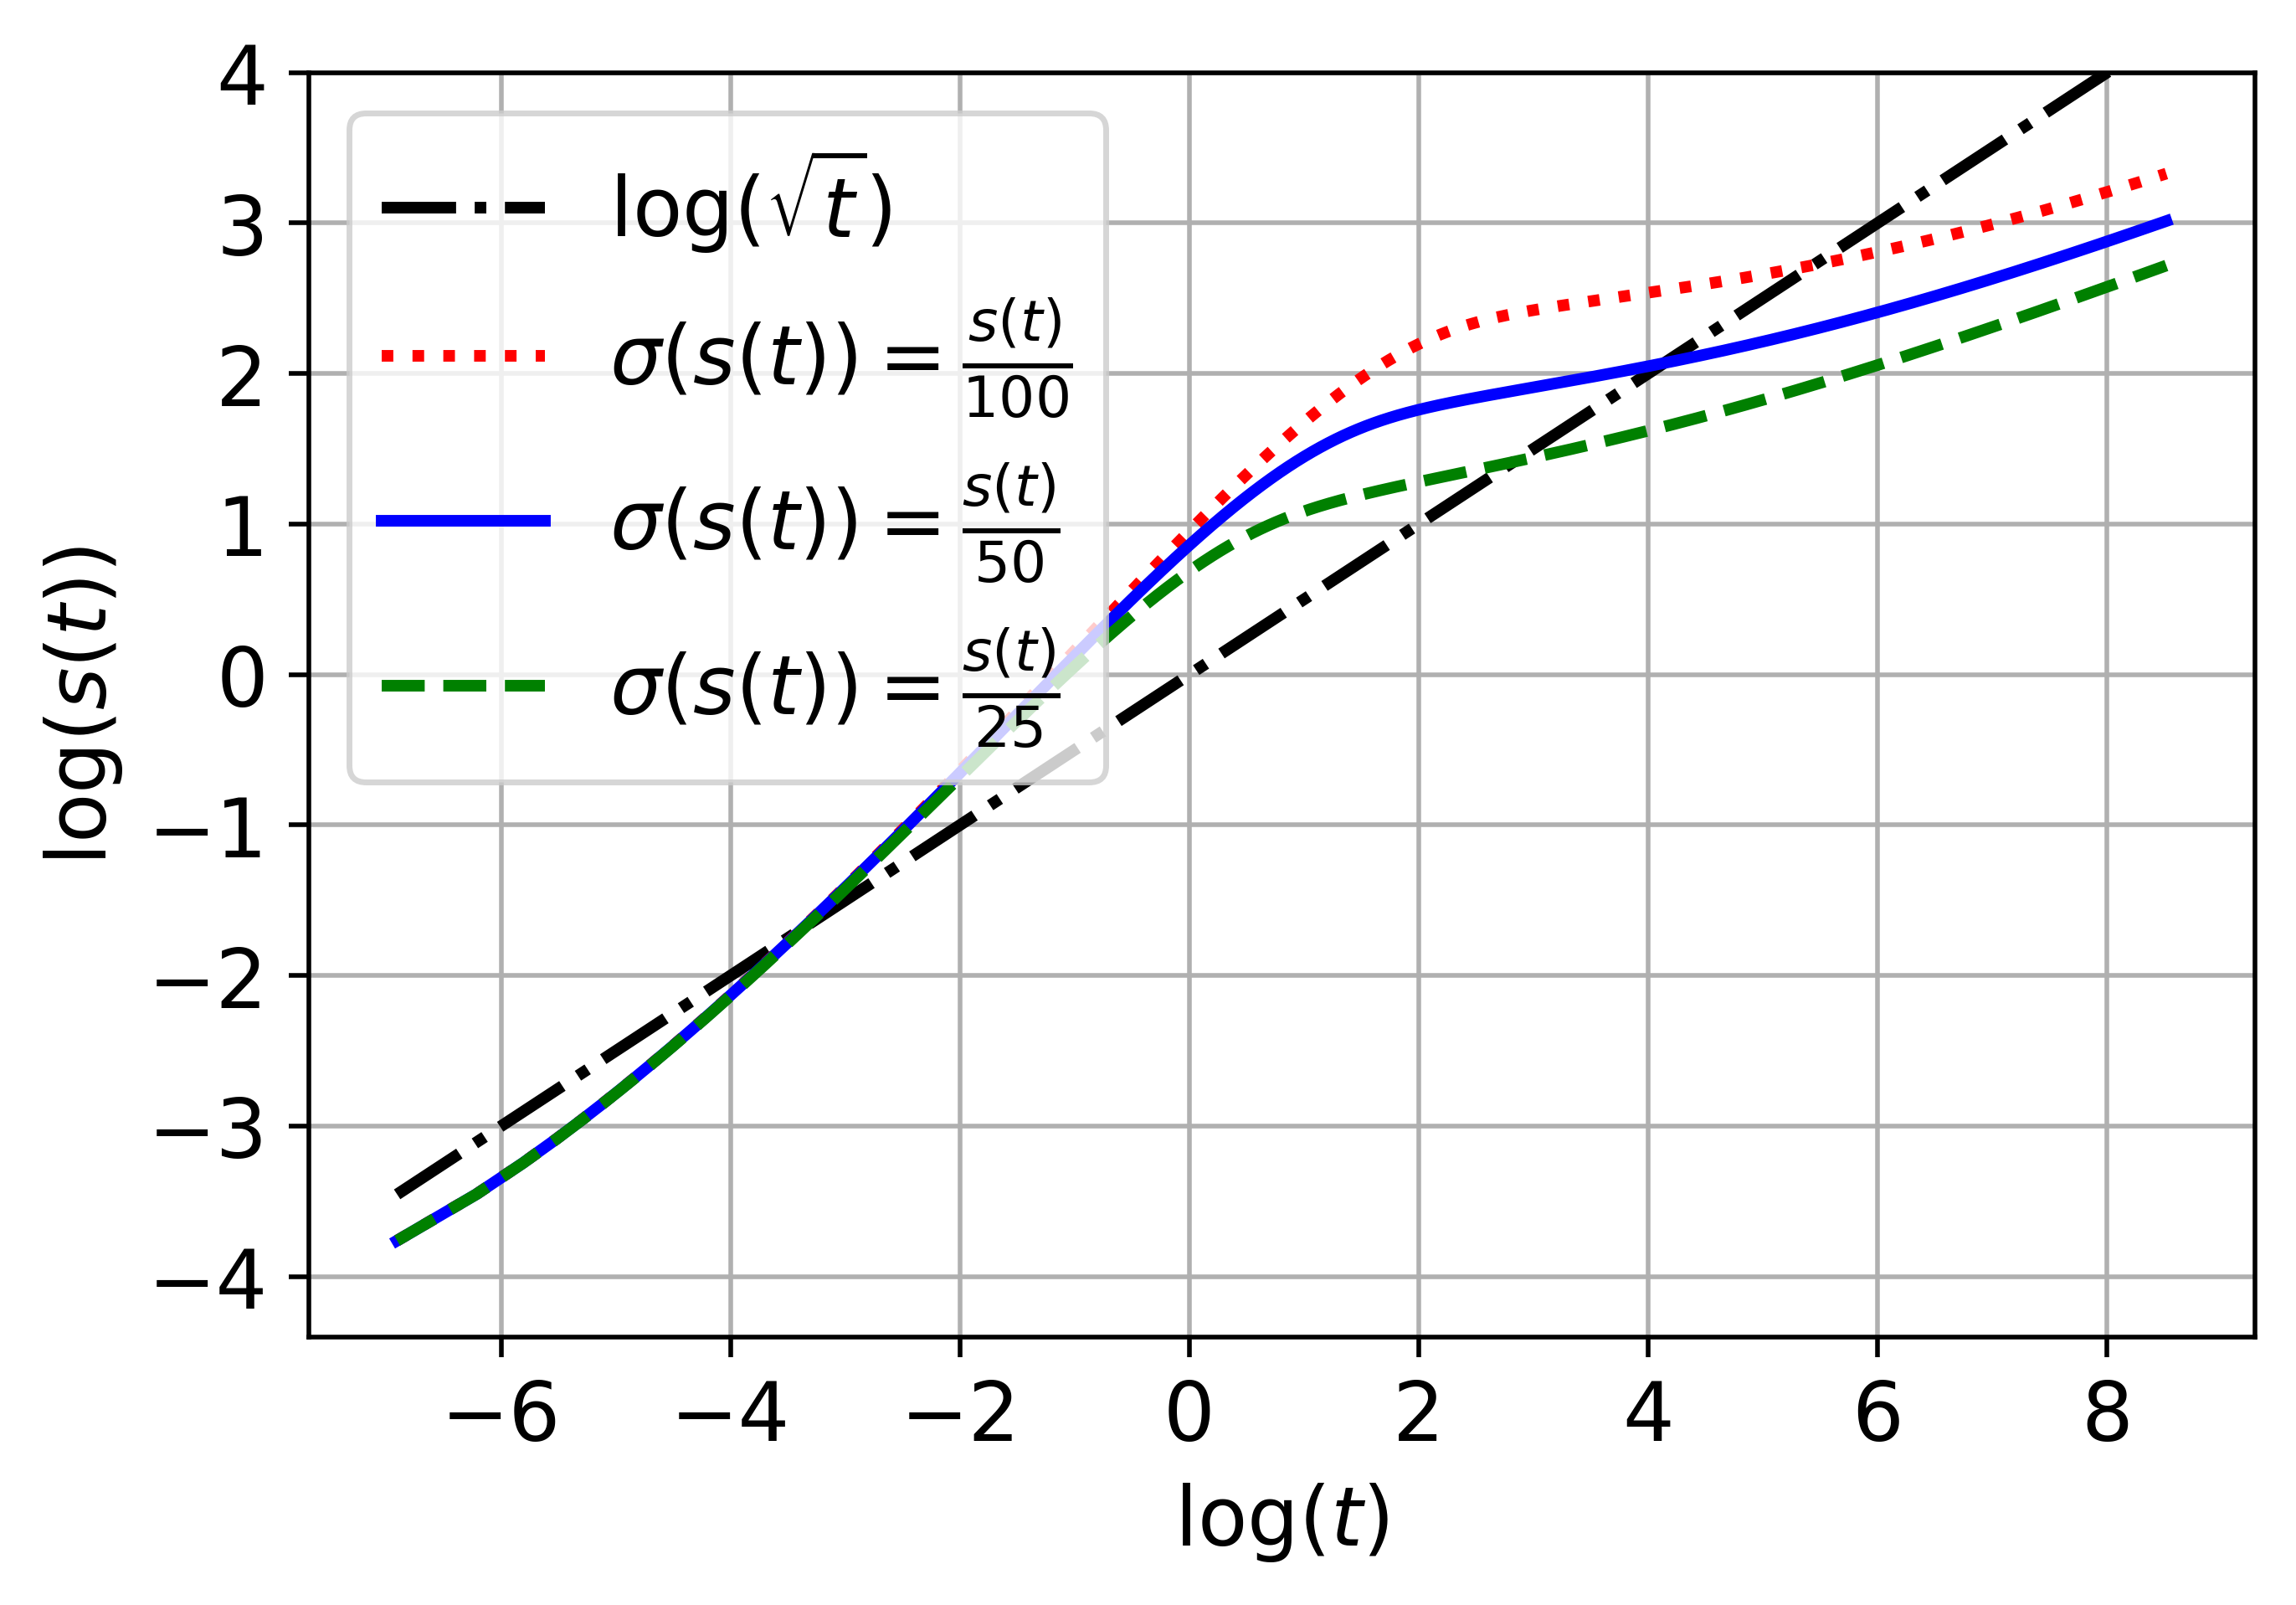

[array([0.40184547]), array([0.3605881]), array([0.32252626])]


In [22]:
from numpy import * 
from pylab import *
from scipy.optimize import curve_fit
import scipy.sparse  
from scipy.sparse import diags 
from scipy.integrate import odeint 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit # to fit the data in some curve
from itertools import cycle # need in for loop to plot with different dotted lines
D = 0.000366 # mm^2/minute
beta = 0.564# mm/minute#
H = 2.5 # Henry's constant (dimensionless)
#### parameter based on experimental
S_0 = 0.01
x_c = 10
####
a_0 = 2000
m_0 = 0.1
m_ref = m_0
### constraints paramter 
b = 1
#dimensionless number
A_0 = a_0 *m_ref* x_c/D
print('A_0=', A_0)
Bi = beta*x_c/D
print('Biot=', Bi)
#######
h_0 = S_0/x_c
####time #####
T_f = 5000 #final time in dimension form (minutes)
deltaT = 0.001 # timestep in dimension form
t_c = x_c**2/D ## time scale
print('T_f=',t_c) 
T_s = T_f/t_c 
print('T_s=',T_s)
Tmax =T_s
T = int(T_f/deltaT) # total number of nodes in time step
print('T=', T)
Time_step_nd = T_s/(T-1) # time step in dimensionless form
Time_step_d = t_c*T_s/(T-1) # time step in dimension form
print('Time step in dimensionless form =', T_s/(T-1))# time step in dimensionless form
print('Time step in dimension form =', t_c*T_s/(T-1))# time step in dimension form
T_exp = [0, 3.5, 10, 30, 150, 200, 400, 4320]# experimental data given in time (minutes)
T_slice = [round(number /Time_step_d) for number in T_exp] # time slice to plot the experiment 
print("T_slice=", T_slice)
###space discretization in dimensionless form
N = 100
x = linspace(0,1,N) 
h = 1/(N -1) 
##### tridiagonal matrix for M time derivative 
M = diags([h/6, 2*h/3, h/6], [-1, 0, 1], shape=(N, N)).toarray() 
M[0,0] = M[0, 0]/2 
M[N-1, N-1] =  M[N-1, N-1]/2 
#print('M =', M) 
Min = linalg.inv(M) 
#######tridiagonal matrix for K (grad(u).grad(phi)) 
K = diags([-1/h, 2/h, -1/h], [-1, 0, 1], shape=(N, N)).toarray() 
K[0,0] = K[0, 0]/2 
K[N-1, N-1] =  K[N-1, N-1]/2 
#print(K) 
######## tridigonal matrix for mixed term  
diagonals = zeros((3, N))   # 3 diagonals 
diagonals[0,:] = linspace(-1, -N, N) 
for i in range(1, N-1): 
    diagonals[1,i] = 2*h/3 - (x[i-1] + x[i+1])/2  
diagonals[1, 0] = h/3 - x[1]/2  
diagonals[1, N-1] = h/3 - x[N-2]/2     
for i in range(N-1):     
    diagonals[2,i+1] = x[i+1]/2 - h/3 
for i in range(N-1):     
    diagonals[0,i] = x[i]/2 - h/3   
k = array([diagonals[0,0:N-1], diagonals[1], diagonals[2,1:]]) 
A = diags(k,[-1,0,1]).toarray() 
#vectors e_1 and e_{N} (it is needed for boundary terms)
E1 = N*[0] 
E1[0] = 1
EN = N*[0]
EN[N-1] = 1
#print(EN)
G = print(dot(K,E1))
In = [1/100, 1/50, 1/25]  #for linear sigma
#In = [1000, 2500, 4000] # different values for a_0
Sigma_t = []
MV_BC = []
for alpha in In:
    #A_0 = alpha*m_ref*S_f/D
    def Model(u, t): 
        dwdt = A_0*(u[N-1] - alpha/x_c*u[N]/m_ref) 
        dudt = (dwdt/u[N])*dot(dot(Min, A), u[0:N]) - (1/(u[N])**2)*dot(dot(Min, K), u[0:N]) + (1/u[N])*Bi*(b/m_ref - H*u[0])*dot(Min,E1) - (dwdt/u[N])*u[N-1]*dot(Min,EN)   
        dudt = list(dudt) 
        dudt.append(dwdt) 
        return dudt
    u0 = (N)*[m_0/m_ref] 
    u0.append(h_0) 
    #print(u0) 
    #time discretization
    t = linspace(0, Tmax, T) 
     #solve ODE 
    z = odeint(Model, u0, t) 
    m = z[:,:-1]
    res = [sum(e)/(N) for e in m]
    #print(res)
    #plotting u(tau, y) vs h(tau)    
    h=z[:,-1]# extracting the data of moving boundary
    print('length=', len(h))
    # to go back to moving domain
    h0 = x*h[T_slice[0]]    
    h1 = x*h[T_slice[1]]
    h2 = x*h[T_slice[2]]
    h4 = x*h[T_slice[3]]
   # h5 = x*h[T_slice[7]]
    h6 = x*h[round(T/8)]
    h8 = x*h[round(T/4)]
    h10 = x*h[round(T/2)]
    h20 = x*h[round(3*T/4)]
    h30 = x*h[T-1]
    plt.plot(h0,z[T_slice[0],0:N])
    plt.plot(h1,z[T_slice[1],0:N])
    plt.plot(h2,z[T_slice[2],0:N])
    plt.plot(h4,z[T_slice[3],0:N])
    plt.plot(h6,z[round(T/8),0:N])
    plt.plot(h8,z[round(T/4),0:N])
    plt.plot(h10,z[round(T/2),0:N])
    plt.plot(h20,z[round(3*T/4),0:N])
   # plt.plot(h5,z[T_slice[7],0:N])
    plt.plot(h30,z[T-1,0:N])
    plt.xlabel('z') 
    plt.ylabel(r'u($\tau$, z)') 
    plt.legend([r"$\tau = 0$", r"$\tau= 0.0025$", r"$\tau = 0.005$", r"$\tau= 0.025$", r"$\tau = 0.125$", r"$\tau= 0.25$",  r"$\tau= 0.5$", r"$\tau = 0.75$", r"$\tau = 1$"])
    #plt.ylim(0.9,1.1)
    plt.grid()
    plt.show()
   #ploting m(t, x) vs t (dimesion domain and time)
    t_1 = t*t_c
    print('T=', t_1)
    x_0 = h0*x_c
    x_1 = h1*x_c
    x_2 = h2*x_c
    x_4 = h4*x_c
    #x_5 = h5*x_c
    x_6 = h6*x_c
    x_8 = h8*x_c
    x_10 = h10*x_c
    x_20 = h20*x_c
    x_30 = h30*x_c
    plt.figure(dpi=500)
    # plotting conncentation profile for large time with final time T = 5000
    #plt.plot(x_0, m_0*z[T_slice[0],0:N], linewidth=2)
    plt.plot(x_1, m_0*z[T_slice[1],0:N], linewidth=2)
    plt.plot(x_2, m_0*z[T_slice[2],0:N], linewidth=2)
    plt.plot(x_4, m_0*z[T_slice[3],0:N], linewidth=2)
    plt.plot(x_6, m_0*z[round(T/8),0:N], linewidth=2)
    plt.plot(x_8, m_0*z[round(T/4),0:N], linewidth=2)
    plt.plot(x_10, m_0*z[round(T/2),0:N], linewidth=2)
    #plt.plot(x_20, m_0*z[round(3*T/4),0:N], linewidth=2)
    #plt.plot(x_5, m_0*z[T_slice[7],0:N], linewidth=2)
    plt.plot(x_30, m_0*z[T-1,0:N], linewidth=2)
    fontsize = 14
    fontweight = 'normal'
    ax = gca()
    fontproperties = {'weight' : fontweight, 'size' : fontsize}
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    plt.xlabel('Penetration region, [mm]',  fontsize= fontsize, fontweight=fontweight) 
    plt.ylabel(r'Concentration,  [g/mm$^3$]', fontsize= fontsize, fontweight=fontweight) 
    plt.axis([-0.1, 13, 0, 0.43])
    plt.legend([r"$t= 3.5$ min", r"$t = 10$ min", r"$t= 30$ min",\
                r"$t = 625$ min", r"$t=  1250$ min",  r"$t= 2500$ min", r"$t= 5000$ min"], prop=fontproperties)
    plt.grid()
    plt.show()
    #ploting the concentration profile to mimic the experiment   
    h01 = x*h[T_slice[1]]
    h02 = x*h[T_slice[2]]
    h04 = x*h[T_slice[3]]
    plt.plot(h01,z[T_slice[1],0:N])
    plt.plot(h02,z[T_slice[2],0:N])
    plt.plot(h04,z[T_slice[3],0:N])
    plt.xlabel('z') 
    plt.ylabel(r'u($\tau$, z)') 
    plt.legend([r"$\tau = 0$", r"$\tau= 0.0025$", r"$\tau = 0.005$", r"$\tau= 0.025$", r"$\tau = 0.125$", r"$\tau= 0.25$",  r"$\tau= 0.5$", r"$\tau = 0.75$", r"$\tau = 1$"])
    #plt.ylim(0.9,1.1)
    plt.grid()
    plt.show()
#     #plot m(t, x) vs t (dimensional form)
    x_11 = h01*x_c
    x_21 = h02*x_c
    x_41 = h04*x_c
    #plt.plot(x_0, m_0*z[T_slice[0],0:N], linewidth=2)
    plt.figure(dpi=500)
    plt.plot(x_0, m_0*z[T_slice[0],0:N], linewidth=2) # T=  0 min
    plt.plot(x_1, m_0*z[T_slice[1],0:N], linewidth=2) # T = 3.5 min
    plt.plot(x_2, m_0*z[T_slice[2],0:N], linewidth=2) # T = 10 min
    plt.plot(x_4, m_0*z[T_slice[3],0:N], linewidth=2) # T = 30 min
   # plt.plot(x_5, m_0*z[T_slice[7],0:N], linewidth=2)
    fontsize = 14
    fontweight = 'normal'
    ax = gca()
    fontproperties = {'weight' : fontweight, 'size' : fontsize}
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    plt.xlabel('Penetration region,  [mm]', fontsize= fontsize, fontweight=fontweight) 
    plt.ylabel(r'Concentration,  [g/mm$^3$]', fontsize= fontsize, fontweight=fontweight) 
    plt.axis([-0.02, 12, 0, 0.42])
    #plt.xlim(0,7.5)
    plt.legend([r"$t= 0$ min" ,r"$t= 3.5$ min", r"$t = 10$ min", r"$t= 30$ min"], prop=fontproperties)
    plt.grid()
    plt.show()
    ###### for log log plot we are removing the first value 0 for time span
    St = x_c*z[:,N]
    St0 = delete(St, 0) #we remove the 0, since log(0) is not defined. 
    Sigma_t.append(St0)
    MV_BC.append(St)
    plt.figure(dpi=500)
    plt.plot(t_1, x_c*z[:,N], linewidth=2) 
    #plt.plot([0, 3.5, 10, 30], [0, 5, 6, 7], "*", linewidth=5)
    plt.plot([0, 3.5, 10, 30], [0, 1, 2, 2], "o", linewidth=5)
    ax = gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    plt.xlabel(r'Time, [min]', fontsize= fontsize, fontweight=fontweight) 
    plt.ylabel(r' Diffusion front, [mm]', fontsize= fontsize, fontweight=fontweight) 
    plt.axis([-0.15, 40.2, -0.4, 13])
    #plt.xlim(-0.2,40)
    plt.legend([r"Numerical result", r"Experiment data"], loc='upper left', prop=fontproperties ) # loc='upper left', frameon=False
    plt.grid()
    plt.show()
    #log log plot
    plt.plot(log(t_1[1:]), log(St[1:]), linewidth=2) 
    plt.plot(log(t_1[1:]), log(sqrt(t_1[1:])), linewidth=2) 
    plt.grid()
    plt.show()
#plotting diffisant front for different values of sigma and a_0 in one plot   
fontsize = 14
fontweight = 'normal'
lines = ["-","--","-.", ':']
colors = ['r', 'b', 'g', 'k']
linecycler = cycle(lines)
plt.figure(dpi=500)
for i in range(len(MV_BC)): 
    color = colors[i]
    plt.plot(t_1, MV_BC[i], next(linecycler), color = color, linewidth = 2)
#plt.plot([0, 3.5, 10, 30], [0, 1, 2, 2],'o', linewidth=2)    
plt.plot([0, 3.5, 10, 30], [0, 5, 6, 7],'o', linewidth=2)
ax = gca()
fontproperties = {'weight' : fontweight, 'size' : fontsize}
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight(fontweight)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight(fontweight)
plt.xlabel(r'Time, [min]',fontsize= fontsize, fontweight=fontweight) #, fontsize='large'
plt.ylabel(r' Diffusion front, [mm]', fontsize = fontsize,  fontweight= fontweight) 
    #plt.ylim(0,500)
#plt.axis([-0.1, 40, -0.02, 4.5])
plt.axis([-0.1, 40, -0.06, 25])
# plt.axis([-0.15, 40.2, -1000000000000000, 185000000000000000])
#plt.xlim(-0.2,40)
#plt.legend([r"$\sigma(s(t))=\frac{s(t)}{20}$", r"$\sigma(s(t))= \frac{s(t)}{10}$", r"$\sigma(s(t))= \frac{s(t)}{5}$", r"Experimental data"], prop=fontproperties, loc='upper right' )
#plt.legend([r"$a_0=1000$", r"$a_0 = 2500$", r"$a_0 = 4000$", r"Experimental data"], prop=fontproperties,  loc='upper left' )
plt.legend([r"$\sigma(s(t))=\frac{s(t)}{100}$", r"$\sigma(s(t))= \frac{s(t)}{50}$", r"$\sigma(s(t))= \frac{s(t)}{25}$", r"Experimental data"], prop=fontproperties, loc='upper left' )
plt.grid()
plt.show()
#plotting log-log plot in one one figures
plt.figure(dpi=500)
plt.plot(log(t_1[1:]), log(sqrt(t_1[1:])), color = 'k',  linestyle = '-.',  linewidth=2) 
for i in range(len(Sigma_t)):
    color = colors[i]
    plt.plot(log(t_1[1:]), log(Sigma_t[i]), next(linecycler), color = color, linewidth = 2)     
#plt.plot(log(t_1[1:]), log(Sigma_t[1]), linestyle = '-', linewidth=2) 
#plt.plot(log(t_1[1:]), log(Sigma_t[2]), linestyle = '-', linewidth=2)#, marker = 's', mec = 'brown', mfc = 'green', mew = 1, ms = 2)
ax = gca()
fontproperties = {'weight' : fontweight, 'size' : fontsize}
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight(fontweight)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight(fontweight)
plt.xlabel('log($t$)', fontsize= fontsize, fontweight=fontweight) 
plt.ylabel(r'log($s(t)$)', fontsize= fontsize, fontweight=fontweight) 
plt.ylim(-4.4, 4)
#plt.axis([0, 9, -1, 6])
#plt.legend([r"log($\sqrt{t})$", r"$\sigma(s(t)) = \frac{s(t)}{20}$", r"$\sigma(s(t)) =\frac{s(t)}{10} $", r"$\sigma(s(t)) = \frac{s(t)}{5}$"], prop=fontproperties, loc='upper left')
#plt.legend([r"log($\sqrt{t})$", r"$a_0 = 100$", r"$a_0=500$", r"$a_0 =1000$"], prop=fontproperties, loc='upper left' )
plt.legend([r"log($\sqrt{t})$", r"$\sigma(s(t)) = \frac{s(t)}{100}$", r"$\sigma(s(t)) =\frac{s(t)}{50} $", r"$\sigma(s(t)) = \frac{s(t)}{25}$"],prop=fontproperties, loc='upper left')
#plt.legend([r"$log(\sqrt{t})$" ,r"$\sigma(s(t))=\frac{s(t)}{100}$", r"$\sigma(s(t))= \frac{s(t)}{50}$", r"$\sigma(s(t))= \frac{s(t)}{25}$"], prop=fontproperties, loc='upper left')
#plt.legend([r"log($\sqrt{t})$", r"$a_0 = 1500$", r"$a_0=2000$", r"$a_0 =2500$"], loc='upper left' )
plt.grid()
plt.show()
#fitting values for gamma
def func(t, b):
    return t**b
#D = log(Sigma_t[0]-S_0)[5]
Slope =[]
Fit_values = []
for j in range(len(Sigma_t)):
    popt, pcov = curve_fit(func, t_1[1:], Sigma_t[j])
    Fit_values.append( popt)
print(Fit_values)
